<a href="https://colab.research.google.com/github/GStravinsky/Image-Cell-Count/blob/master/Ass_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Loading libraries and data.

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage.color import rgb2hed
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
from scipy.stats import entropy
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR, LinearSVR
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
from keras.callbacks import ModelCheckpoint
from sklearn import preprocessing

Using TensorFlow backend.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Import and preprate the data
D = h5py.File('/content/drive/My Drive/breast.h5', 'r') 
X,Y,P = D['images'],np.array(D['counts']),np.array(D['id'])

The challenge webpage indicates that the area equal to 16px of a border around the edges was not used to count the number of  lymphocytes. Thus, I have decided to trim this area.

In [0]:
# trimming the are of the images equal to 16px
X = X[:,16:283,16:283,:]

In [0]:
# !!!!!!!!REMOVE THIS!!!!!!!!!!
#hed_data = np.load("hed_data.npy")
#projected_blue_train = np.load("projected_blue_train.npy")
#projected_green_train = np.load("projected_green_train.npy")
#projected_red_train = np.load("projected_red_train.npy")
#projected_brown_train = np.load("projected_brown_train.npy")
hed_blue = np.load("hed_blue.npy")
features_train = np.load("features_train.npy")
features_test = np.load("features_test.npy")

## Question 1


### i) Data breakdown

There are 5841 training examples and 1563 testing examples in the data. 

In [0]:
# number of train examples
np.sum(P<14)

5841

In [0]:
# number of test examples
np.sum(P>=14)

1563

### ii) Showing Images

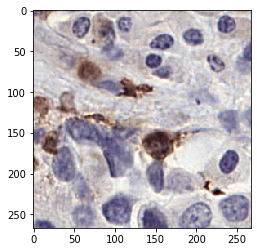

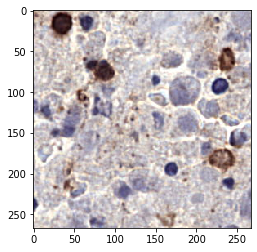

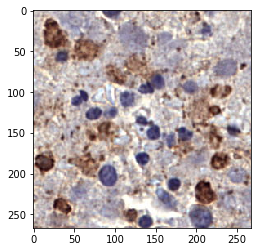

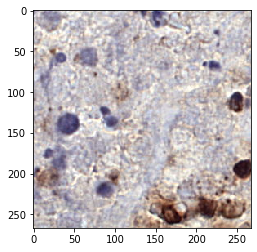

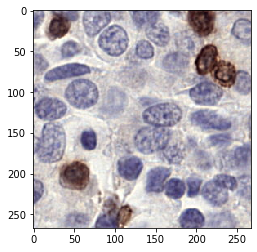

In [0]:
# showing images
for i in range(0,5): 
    plt.imshow(X[i])
    plt.show()

In [0]:
# Seeing respective count values
Y[0:5]

array([4, 4, 9, 5, 6], dtype=int32)

The images show tissue with brown and blue cells on a light background. The brown cells are the cells of interest, however, how "easy" it is to count them varies. For example, the last image on display clearly shows that there are 6 lymphocytes whilst all the other images on display portray a more ambigious cases. It seems that the medical specialists were only counting the big and rather bold cells ignoring the small and bright ones. However, as the penultimate image with count 5 shows, this might not be a strong rule. 

### iii) Histogram

(array([6.438e+03, 6.690e+02, 1.930e+02, 5.800e+01, 3.300e+01, 9.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0.,  7., 14., 21., 28., 35., 42., 49., 56., 63., 70.]),
 <a list of 10 Patch objects>)

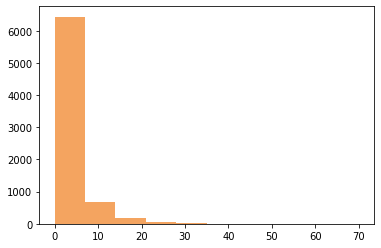

In [0]:
# crude histogram
plt.hist(Y, color = "sandybrown")

The histograms above indicates a strong right skew. This indicates the majority of the values resting within 0 to 10 cells as well asthat there are some outliers which need to be investigated. To investigate the outliers, I first want to see how many of them there are.

In [0]:
# how many big values - might impose a problem.
np.sum(Y>40)

5

In [0]:
# are there any with more than 200?
np.sum(Y>200)

0

There are only 5 values which are larger than 40 and non of the values are larger than 200 (thus I will exclude larger than 200 from the histogram required). The required histogram is presented bellow. 

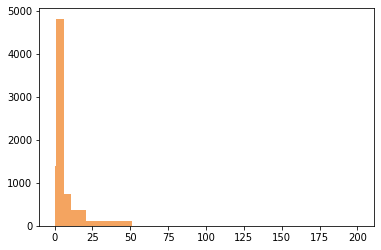

In [0]:
# histogram by the (roughly) required bins. (I know there are no >200)
(histogram_counts, bins, _) = plt.hist(Y, bins = [0,1,6,11,21,51,201], color = "sandybrown")
plt.show()

In [0]:
np.set_printoptions(suppress=True)
print(histogram_counts)
print(bins)

[1397. 4811.  736.  356.  103.    1.]
[  0   1   6  11  21  51 201]


As before, the majority of the values lie between 0 to 51. There is only one value greater than 51. I want to examine it closer.

In [0]:
Y[Y>50]

array([70], dtype=int32)

Only one image has a cell count of 70. This sounds like an enormous number and I want to check the image with this count. It is important because if this is a mistake and not a real count, it might influence the output too much.

(array([2892]),)


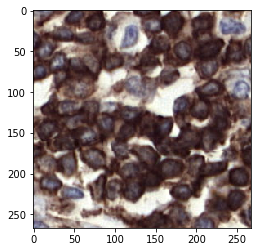

In [0]:
print(np.where(Y==70))
plt.imshow(X[2892])
plt.show()

Okay, there are a lot of brown cells here. I am leaving this observation untouched.

### iv) Pre-processing

To save time and stop my RAMs from crashing I have decided to transform the pre-processed brown layer data to int8 format from the original float32

In [0]:
np.shape(X)

(7404, 267, 267, 3)

In [0]:
hed_data = rgb2hed(X[:1000,:,:,:])[:,:,:,2]
hed_data = (hed_data * 128).astype("int8")

In [0]:
hed_data_2 = rgb2hed(X[1000:2000])[:,:,:,2]
hed_data_2 = (hed_data_2 * 128).astype("int8")

In [0]:
hed_data = np.vstack((hed_data, hed_data_2))

In [0]:
hed_data_2 = rgb2hed(X[2000:3000])[:,:,:,2]
hed_data_2 = (hed_data_2 * 128).astype("int8")

In [0]:
hed_data = np.vstack((hed_data, hed_data_2))

In [0]:
hed_data_2 = rgb2hed(X[3000:4000])[:,:,:,2]
hed_data_2 = (hed_data_2 * 128).astype("int8")

In [0]:
hed_data = np.vstack((hed_data, hed_data_2))

In [0]:
hed_data_2 = rgb2hed(X[4000:5000])[:,:,:,2]
hed_data_2 = (hed_data_2 * 128).astype("int8")

In [0]:
hed_data = np.vstack((hed_data, hed_data_2))

In [0]:
hed_data_2 = rgb2hed(X[5000:6000])[:,:,:,2]
hed_data_2 = (hed_data_2 * 128).astype("int8")

In [0]:
hed_data = np.vstack((hed_data, hed_data_2))

In [0]:
hed_data_2 = rgb2hed(X[6000:])[:,:,:,2]
hed_data_2 = (hed_data_2 * 128).astype("int8")

In [0]:
hed_data = np.vstack((hed_data, hed_data_2))
del(hed_data_2)
# saving data for later use
np.save("hed_data", hed_data)

Showing the pre-processed images.

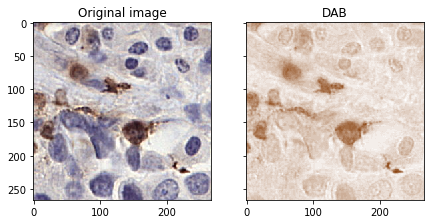

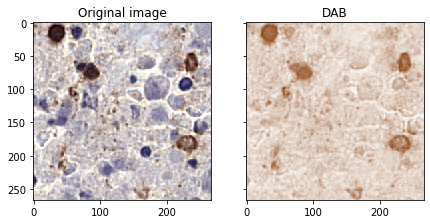

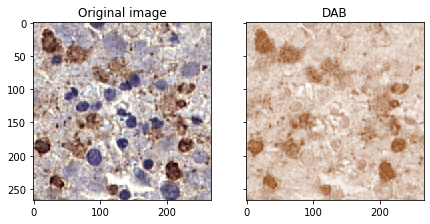

In [0]:
cmap_hema = LinearSegmentedColormap.from_list('mycmap', ['white', 'navy'])
cmap_dab = LinearSegmentedColormap.from_list('mycmap', ['white', 'saddlebrown'])
cmap_eosin = LinearSegmentedColormap.from_list('mycmap', ['darkviolet', 'white'])

for i in range(0,3):
  fig, axes = plt.subplots(1, 2, figsize=(7, 6), sharex=True, sharey=True)
  ax = axes.ravel()
  ax[0].imshow(X[i,])
  ax[0].set_title("Original image")

  ax[1].imshow(hed_data[i,], cmap=cmap_dab)
  ax[1].set_title("DAB")

### v) Scatter Plot

Creating a data for an average "brownness" scatter plot.

In [0]:
average_brown = []
for i in range(0, np.shape(hed_data)[0]):
    average_brown.append(np.mean(hed_data[i]))
    
average_brown = np.asarray(average_brown)  

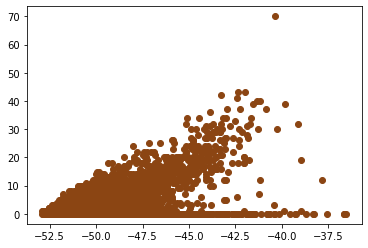

In [0]:
plt.scatter(average_brown, Y, color = "saddlebrown")

The scatter plot above shows a strong possitive correlation. The higher the number of cells - the more "browness" there is. A lot of zero values for the cell count too and they correspond to different shades of brown which might lead to miscalculations. Looking into pictures, we see that the size of the brown cells varies, and if they are smaller it might appear that the image is less brown, but the count of the cells might, nonetheless,be non-zero. Hence, this is a problem and we need to look for additional covariates.

### vi) Number of images per patient

In [0]:
np.unique(P, return_counts = True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18], dtype=int32),
 array([320, 465, 958, 192,  44, 105,  83, 632, 533, 552, 761, 791, 405,
        105, 399, 604, 103, 352]))

The number of images per patient is not even, yet I do not think it is a problem. We are not looking into person specific problem, but instead we want to develop an algorithm that could predict the number of cells given any image. We must not rely on the prior knowledge - the prior cell count of the person. If we were to include covariates such as age, gender, lifestyle, etc to improve our anlysis then the individual counts might be more important.

### vii) Performance measure

I think that MAE would be a better performance metric. There are two reasons behind it. First, I see some big outliers (cell counts of more than 40, 70), thus it is unlikelly that the model will predict them very acuratelly. As a results, MSE would explode in the presence of such an error. Furthermore, I think that it is reasonable to treat the error of, for instance, 10 as twice as bad as the error equal to 5. MAE achieves this whilst it is not the case for MSE and RMSE where the former would consider an error of 10 to be 4 times worse as the error of 5. I assume that giving uniform weights to error is reasonable mostly because I lack justification to prove otherwise. In the case where a bigger error could lead to wrong treatments, RMSE might become a more appropriate measure.

## Question 2

### i) Extracting features

### a. Averages

Initially, I start by extracting average color from all the layers. Average "browness" has been extracted before in Question 1, thus I will not do it again here. I plot scatter plots of each measures below as well as report the correlation coefficients of each feature will cell counts. 

In [0]:
# average red
average_red = []
for i in range(0, np.shape(X)[0]):
    average_red.append(np.mean(X[i,:,:,1]))
    
# transforming into array    
average_red = np.asarray(average_red)    
#np.save("average_red", average_red)

In [0]:
# average green
average_green = []
for i in range(0, np.shape(X)[0]):
    average_green.append(np.mean(X[i,:,:,1]))
# transforming into array     
average_green = np.asarray(average_green)    
#np.save("average_green", average_green)

In [0]:
# average blue
average_blue = []
for i in range(0, np.shape(X)[0]):
    average_blue.append(np.mean(X[i,:,:,2]))
average_blue = np.asarray(average_blue)
#np.save("average_blue", average_blue)

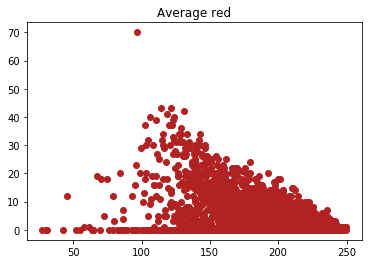

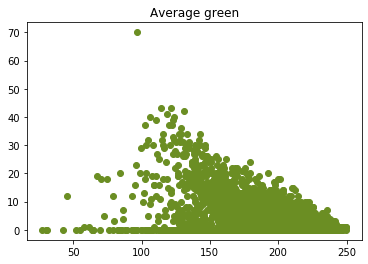

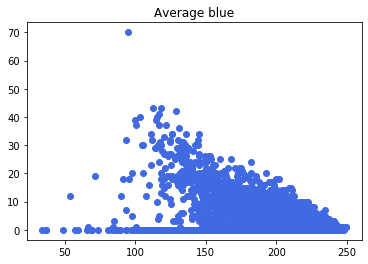

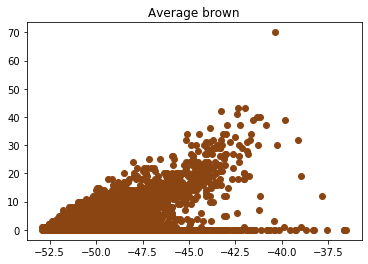

In [0]:
plt.scatter(average_red, Y, color="firebrick")
plt.title("Average red")
plt.show()
plt.scatter(average_green, Y, color="olivedrab")
plt.title("Average green")
plt.show()
plt.scatter(average_blue, Y, color="royalblue")
plt.title("Average blue")
plt.show()
plt.scatter(average_brown, Y, color="saddlebrown")
plt.title("Average brown")
plt.show()

In [0]:
print("Browness and counts correlation:", np.corrcoef(average_brown, Y)[0,1],
     "Blueness and counts correlation:", np.corrcoef(average_blue, Y)[0,1],
     "Redness and counts correlation:", np.corrcoef(average_red, Y)[0,1],
    "Greeness and counts correlation:", np.corrcoef(average_green, Y)[0,1])

Browness and counts correlation: 0.5943402784232866 Blueness and counts correlation: -0.5399668977288241 Redness and counts correlation: -0.47953864857752 Greeness and counts correlation: -0.47953864857752


Browness seems like a reasonble good predictor with some noise at zeros counts (as the challenge page states, the zero counts were artificially created). The correlation coefficient is the largest in absolute terms than the other three channels. Apart from that, all the channels showed a reasonable codependency with the cell counts with blueness being the strongest based on the correlation coefficient among the three RGB layers. This is expected considering that the blue cells are those which "compete" for space with the brown ones. Overall, I believe that all of these four measures are worth keeping in at least for the initial regressions.

### b. Variance

I complete the same analysis as I did for the average color of a filter data.

In [0]:
variance_brown = []
for i in range(0, np.shape(hed_data)[0]):
    variance_brown.append(np.var(hed_data[i]))
    
variance_brown = np.asarray(variance_brown)
#np.save("variance_brown", variance_brown)

In [0]:
variance_red = []
for i in range(0, np.shape(X)[0]):
    variance_red.append(np.var(X[i,:,:,0]))
    
variance_red = np.asarray(variance_red)
#np.save("variance_red", variance_red)

In [0]:
variance_green = []
for i in range(0, np.shape(X)[0]):
    variance_green.append(np.var(X[i,:,:,1]))
    
variance_green = np.asarray(variance_green)
#np.save("variance_green", variance_green)

In [0]:
variance_blue = []
for i in range(0, np.shape(X)[0]):
    variance_blue.append(np.var(X[i,:,:,2]))
    
variance_blue = np.asarray(variance_blue)
#np.save("variance_blue", variance_blue)

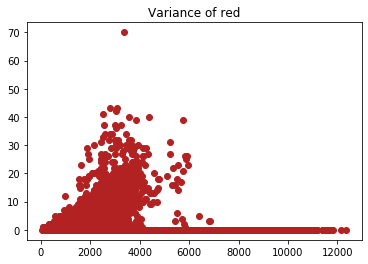

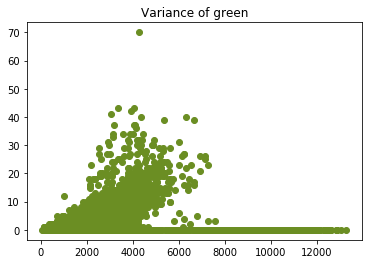

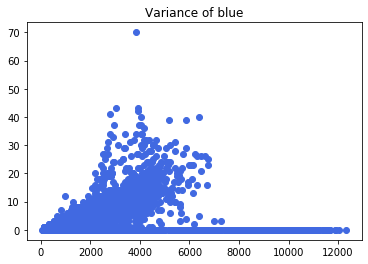

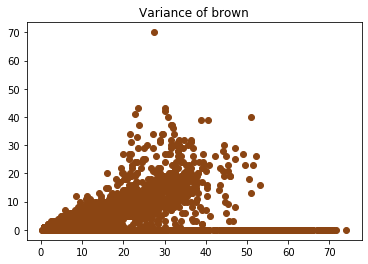

In [0]:
plt.scatter(variance_red, Y, color="firebrick")
plt.title("Variance of red")
plt.show()
plt.scatter(variance_green, Y, color="olivedrab")
plt.title("Variance of green")
plt.show()
plt.scatter(variance_blue, Y, color="royalblue")
plt.title("Variance of blue")
plt.show()
plt.scatter(variance_brown, Y, color="saddlebrown")
plt.title("Variance of brown")
plt.show()

In [0]:
print("Variance of brown and counts correlation:", np.corrcoef(variance_brown, Y)[0,1],
     "Variance of blue and counts correlation:", np.corrcoef(variance_blue, Y)[0,1],
     "Variance of red and counts correlation:", np.corrcoef(variance_red, Y)[0,1],
    "Variance of green and counts correlation:", np.corrcoef(variance_green, Y)[0,1])

Variance of brown and counts correlation: 0.44376068710235117 Variance of blue and counts correlation: 0.31688000351602585 Variance of red and counts correlation: 0.1585806137362525 Variance of green and counts correlation: 0.24875921617035007


From the scatterplots we can see that the variance feature is a worse predictor than the average shade. The issue is that the variance covers almost all possible value space for the zero count data. Nontheless, the variance of browness was the strongest predictor followed by the blueness again. I consider ommiting green and red variance out of the regressions.

### c. Entropy

As before, the calculation of entropy will be followed by the scatter plots and the correlation coefficient with the cell count data.

In [0]:
# entropy red
entropy_red = []
for i in range(0, np.shape(X)[0]):
    # need to reshape the image to get a single value of entropy
    entropy_red.append(entropy(np.reshape(X[i,:,:,0], (267*267, ))))
    
entropy_red = np.asarray(entropy_red)    
#np.save("entropy_red", entropy_red)

In [0]:
# entropy green
entropy_green = []
for i in range(0, np.shape(X)[0]):
    # need to reshape the image to get a single value of entropy
    entropy_green.append(entropy(np.reshape(X[i,:,:,1], (267*267, ))))
    
entropy_green = np.asarray(entropy_green)    
#np.save("entropy_green", entropy_green)

In [0]:
# entropy blue
entropy_blue = []
for i in range(0, np.shape(X)[0]):
    # need to reshape the image to get a single value of entropy
    entropy_blue.append(entropy(np.reshape(X[i,:,:,2], (267*267, ))))
    
entropy_blue = np.asarray(entropy_blue)    
#np.save("entropy_blue", entropy_blue)

In [0]:
# entropy blue
entropy_brown = []
for i in range(0, np.shape(hed_data)[0]):
    # need to reshape the image to get a single value of entropy
    entropy_brown.append(entropy(np.reshape(hed_data[i], (267*267, ))))
    
entropy_brown = np.asarray(entropy_brown)    
#np.save("entropy_brown", entropy_brown)

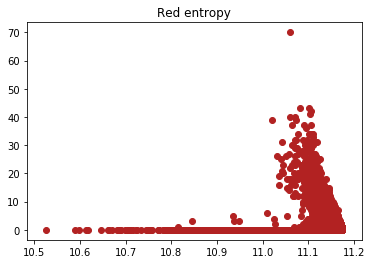

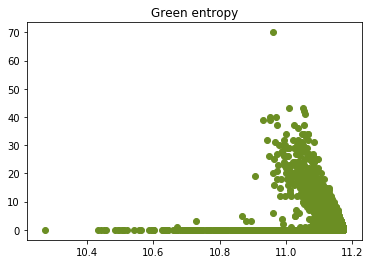

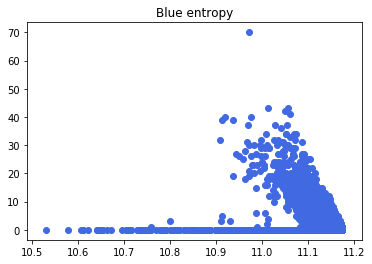

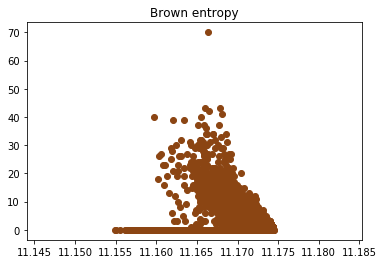

In [0]:
plt.scatter(entropy_red, Y, color="firebrick")
plt.title("Red entropy")
plt.show()
plt.scatter(entropy_green, Y, color="olivedrab")
plt.title("Green entropy")
plt.show()
plt.scatter(entropy_blue, Y, color="royalblue")
plt.title("Blue entropy")
plt.show()
plt.scatter(entropy_brown, Y, color="saddlebrown")
plt.title("Brown entropy")
plt.show()

In [0]:
print("Brown entropy and counts correlation:", np.corrcoef(entropy_brown, Y)[0,1],
     "Blue entropy and counts correlation:", np.corrcoef(entropy_blue, Y)[0,1],
     "Red entropy and counts correlation:", np.corrcoef(entropy_red, Y)[0,1],
    "Green entropy and counts correlation:", np.corrcoef(entropy_green, Y)[0,1])

Browness and counts correlation: -0.4567558461062051 Blueness and counts correlation: -0.2957675441693281 Redness and counts correlation: -0.11597485991939707 Greeness and counts correlation: -0.22160105364351698


As before, the entropy of brown and blue channels are the best predictors for the cell count out of all the four channels. However, even then  the correlation is not great with brown entropy achieving 0.456. It might be the best to only include blue and brown entropies into the the regression.

### d. Histograms

Bellow I am plotting histograms of each channel. I combine all RGB channels into one histogram because they are following very similar patterns. I only plot the histograms of some of the images trying to find those which show some differences.

(array([0.0000e+00, 6.0000e+00, 3.2000e+01, 1.4300e+02, 2.2800e+02,
        3.6300e+02, 6.1400e+02, 2.2660e+03, 6.1320e+03, 1.1681e+04,
        1.3770e+04, 3.1630e+04]),
 array([  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240]),
 <a list of 12 Patch objects>)

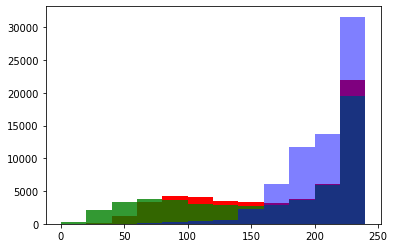

In [0]:
plt.hist(np.reshape(X[2475,:,:,0], (267*267,1)), list(range(0,256, 20)), color = "red")
plt.hist(np.reshape(X[2475,:,:,1], (267*267,1)), list(range(0,256, 20)), color = "green", alpha=0.8)
plt.hist(np.reshape(X[2575,:,:,2], (267*267,1)), list(range(0,256, 20)), color = "blue", alpha=0.5)

(array([ 1113., 13087., 16056.,  7915.,  4211.,  3038.,  4709.,  1872.,
         1726.,  1561.,  1488.,  1411.,  1488.,  3244.,  2046.,  1942.,
         1829.,  1567.,   774.,   212.]),
 array([-55.  , -53.85, -52.7 , -51.55, -50.4 , -49.25, -48.1 , -46.95,
        -45.8 , -44.65, -43.5 , -42.35, -41.2 , -40.05, -38.9 , -37.75,
        -36.6 , -35.45, -34.3 , -33.15, -32.  ]),
 <a list of 20 Patch objects>)

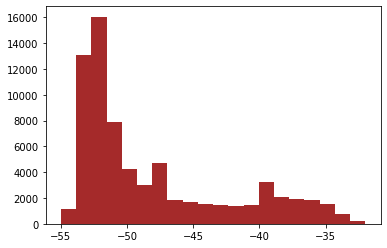

In [0]:
plt.hist(np.reshape(hed_data[2475], (267*267,1)), bins = 20, color = "brown")

This particualar image is dominated by the blue and brown channels with the red and green being less important. This echoes the mean, variance and entropy results observed above.

Now let's examine another image.

(array([  145.,  2616.,  4078.,  3744.,  3048.,  2875.,  3025.,  4603.,
         7394., 14485., 18874.,  6310.]),
 array([  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240]),
 <a list of 12 Patch objects>)

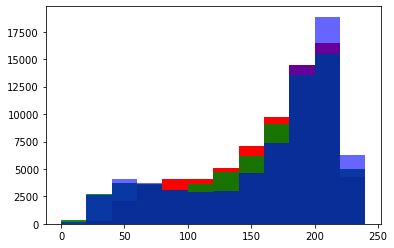

In [0]:
plt.hist(np.reshape(X[3000,:,:,0], (267*267,1)), bins = list(range(0,256, 20)), color = "red")
plt.hist(np.reshape(X[3000,:,:,1], (267*267,1)), bins = list(range(0,256, 20)), color = "green", alpha=0.9)
plt.hist(np.reshape(X[3000,:,:,2], (267*267,1)), bins = list(range(0,256, 20)), color = "blue", alpha=0.6)

(array([  464.,  4715., 14453., 15060.,  7510.,  3968.,  2314.,  1762.,
         1665.,  1560.,  3294.,  1698.,  1728.,  2014.,  2188.,  2344.,
         2212.,  1655.,   630.,    55.]),
 array([-54. , -52.9, -51.8, -50.7, -49.6, -48.5, -47.4, -46.3, -45.2,
        -44.1, -43. , -41.9, -40.8, -39.7, -38.6, -37.5, -36.4, -35.3,
        -34.2, -33.1, -32. ]),
 <a list of 20 Patch objects>)

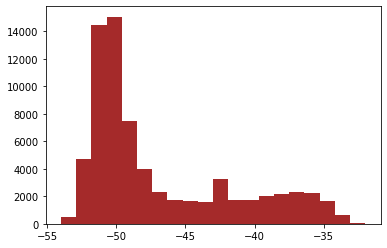

In [0]:
plt.hist(np.reshape(hed_data[3000], (267*267,1)), bins = 20, color = "brown")

In this case the RGB histograms are mostly overlapping - thus one of those channels should be enough for predicting the cell counts. On the other hand, the brown channel is different and offers an informative feature.

Overall, I think there is enough evidence to discard the green and red channels' variances and entropies from the regression.

### e. PC decomposition

The Pricinple Component decomposition will be implemented separatelly for the training and testing data. This is because eigenvectors are formed on the wholes data, not just single observations as was the case for all above features.

Initially, I will try to find onlt 5 PCs to examine are those components any informative. If they all prove to be informative, I will calculate more. In addition, to save time I will use a subset of a training data to test how many components do I need and once that is decided, I will extract the needed number of principal components from the full training and testing data.

In [0]:
# proof-of-concept for red channel
pca_red = PCA(5, svd_solver='randomized')
projected_red = pca_red.fit_transform(np.reshape(X[:1000,:,:,0],(1000, 267*267)))

In [0]:
np.sum(pca_red.explained_variance_ratio_)
# 5 PCs explain 32% of the variation

0.3165841203370672

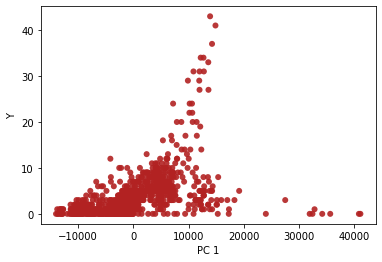

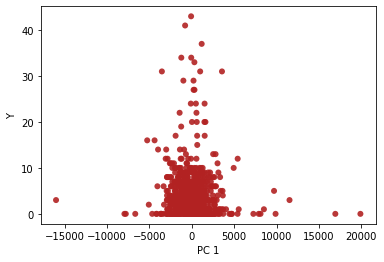

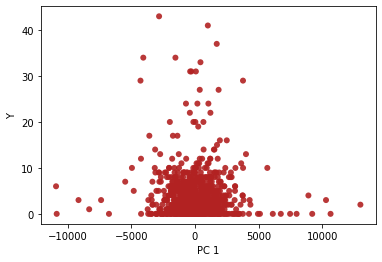

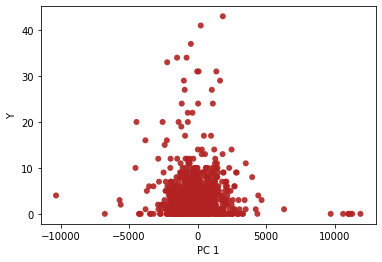

In [0]:
for i in range(0,4):
    plt.scatter(projected_red[:, i], Y[:1000], edgecolor='none', alpha=0.9, color = "firebrick")
    plt.xlabel('PC 1')
    plt.ylabel( 'Y')
    plt.show()

In [0]:
print("PC1 and counts correlation:", np.corrcoef(projected_red[:,0], Y[:1000])[0,1],
     "PC2 and counts correlation:", np.corrcoef(projected_red[:,1], Y[:1000])[0,1],
    "PC3 and counts correlation:", np.corrcoef(projected_red[:,2], Y[:1000])[0,1],
      "PC4 and counts correlation:", np.corrcoef(projected_red[:,3], Y[:1000])[0,1])

PC1 and counts correlation: 0.46315080276403303 PC2 and counts correlation: -0.05430334329447875 PC3 and counts correlation: -0.034978516657744645 PC4 and counts correlation: -0.055985567470259213


From the scatter plots and the correlation coefficients, we see that only the first PC gives meaningful information.

In [0]:
pca_green = PCA(5, svd_solver="randomized")
projected_green = pca_green.fit_transform(np.reshape(X[:1000,:,:,1],(1000, 267*267)))

In [0]:
np.sum(pca_green.explained_variance_ratio_)
# 5 PCs explain 34% of a variance.

0.33912625782274747

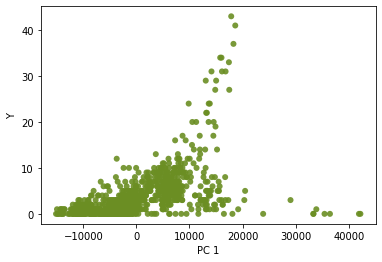

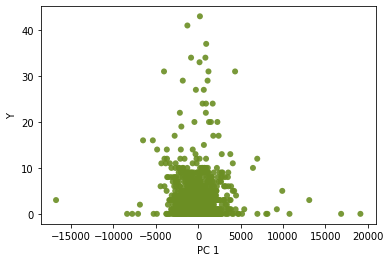

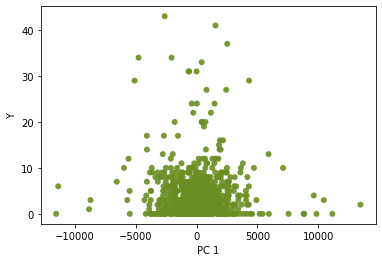

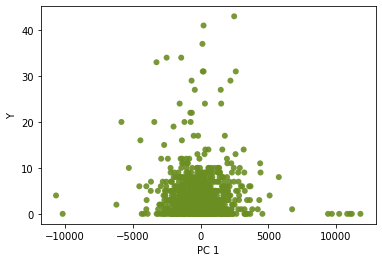

In [0]:
for i in range(0,4):
    plt.scatter(projected_green[:, i], Y[:1000], edgecolor='none', alpha=0.9, color = "olivedrab")
    plt.xlabel('PC 1')
    plt.ylabel( 'Y')
    plt.show()

In [0]:
print("PC1 and counts correlation:", np.corrcoef(projected_green[:,0], Y[:1000])[0,1],
     "PC2 and counts correlation:", np.corrcoef(projected_green[:,1], Y[:1000])[0,1],
    "PC3 and counts correlation:", np.corrcoef(projected_green[:,2], Y[:1000])[0,1],
      "PC4 and counts correlation:", np.corrcoef(projected_green[:,3], Y[:1000])[0,1])

PC1 and counts correlation: 0.5251520920616773 PC2 and counts correlation: -0.04522235989058669 PC3 and counts correlation: -0.034672427260935626 PC4 and counts correlation: -0.04034916082119576


As in the red channel case, only the first principlat component seems to be informative of the cell count.

In [0]:
pca_blue = PCA(5, svd_solver="randomized")
projected_blue = pca_blue.fit_transform(np.reshape(X[:1000,:,:,2],(1000, 267*267)))

In [0]:
np.sum(pca_blue.explained_variance_ratio_)
# 5 PCs explain 39% of a variance.

0.39434053561546883

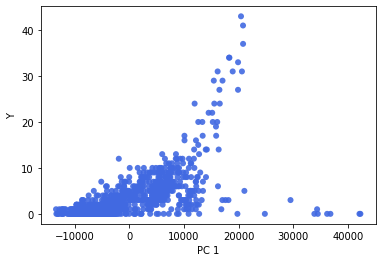

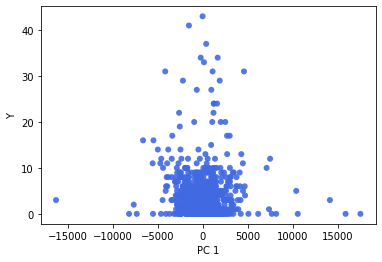

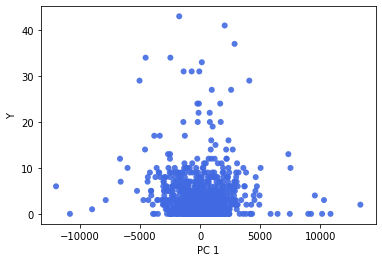

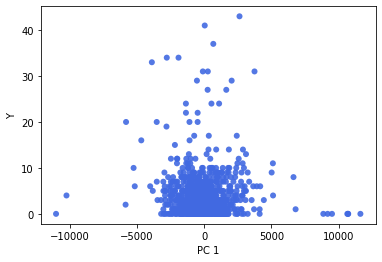

In [0]:
for i in range(0,4):
    plt.scatter(projected_blue[:, i], Y[:1000], edgecolor='none', alpha=0.9, color = "royalblue")
    plt.xlabel('PC 1')
    plt.ylabel('Y')
    plt.show()

In [0]:
print("PC1 and counts correlation:", np.corrcoef(projected_blue[:,0], Y[:1000])[0,1],
     "PC2 and counts correlation:", np.corrcoef(projected_blue[:,1], Y[:1000])[0,1],
    "PC3 and counts correlation:", np.corrcoef(projected_blue[:,2], Y[:1000])[0,1],
      "PC4 and counts correlation:", np.corrcoef(projected_blue[:,3], Y[:1000])[0,1])

PC1 and counts correlation: 0.5943809224982268 PC2 and counts correlation: -0.04170290642440488 PC3 and counts correlation: -0.03365361585308525 PC4 and counts correlation: -0.03770179465904035


Although blue channel is usually more informative than the red or green, this time, similar to the red and green case, only the first PC is important in explaining cell count.

In [0]:
pca_brown = PCA(5, svd_solver="randomized")
projected_brown = pca_brown.fit_transform(np.reshape(hed_data[:1000] ,(1000, 267*267)))

In [0]:
np.sum(pca_brown.explained_variance_ratio_)
# 5 PCs explain 34% of a variance.

0.409220066688186

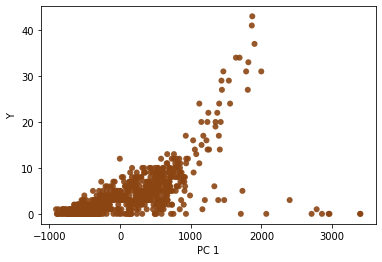

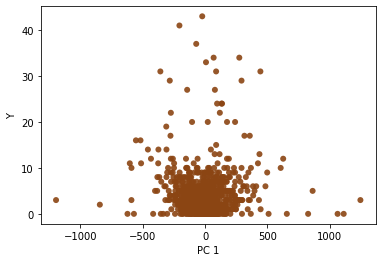

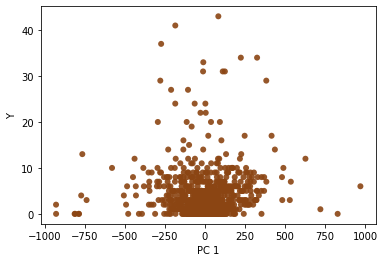

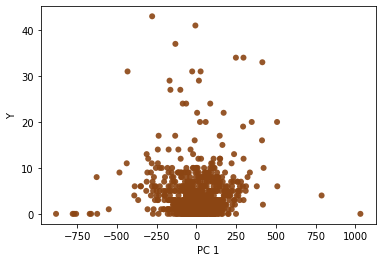

In [0]:
for i in range(0,4):
    plt.scatter(projected_brown[:, i], Y[:1000], edgecolor='none', alpha=0.9, color = "saddlebrown")
    plt.xlabel('PC 1')
    plt.ylabel( 'Y')
    plt.show()

In [0]:
print("PC1 and counts correlation:", np.corrcoef(projected_brown[:,0], Y[:1000])[0,1],
     "PC2 and counts correlation:", np.corrcoef(projected_brown[:,1], Y[:1000])[0,1],
    "PC3 and counts correlation:", np.corrcoef(projected_brown[:,2], Y[:1000])[0,1],
      "PC4 and counts correlation:", np.corrcoef(projected_brown[:,3], Y[:1000])[0,1])

PC1 and counts correlation: 0.6553787384416606 PC2 and counts correlation: -0.03198916230948297 PC3 and counts correlation: 0.03322226433133014 PC4 and counts correlation: 0.029225300608545692


Brown channel also showed that only the first PC is informative in predicting the cell counts. Overall, only the first principal component of all the channels seems to be informative with the rest not being informative. This is because they explain over 20% variation with the rest explaining only a fraction. Furthermore, even though the shapes of RGB PC1 seem the same, their range on PC1 axis is different. Thus I consider putting all the PC1s into the model. 

Now I will create vectors of PC1 for each channel. Separatelly for training and testing data.

#### Extracting PC for the training data

In [0]:
pca_red_train = PCA(1, svd_solver='randomized')
projected_red_train = pca_red_train.fit_transform(np.reshape(X[:5841,:,:,0],(5841, 267*267)))

#np.save("projected_red_train", projected_red_train)

0.23207383098373058

Explained variance ratio [0.23207383]


Text(0, 0.5, 'Y')

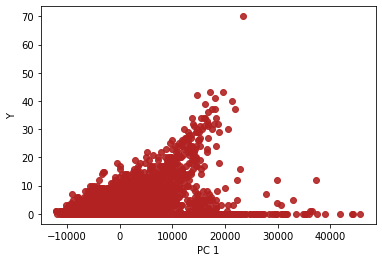

In [0]:
print('Explained variance ratio', pca_red_train.explained_variance_ratio_)
plt.scatter(projected_red_train, Y[:5841], alpha=0.9, color='firebrick')
plt.xlabel('PC 1')
plt.ylabel( 'Y')

In [0]:
pca_green_train = PCA(1, svd_solver='randomized')
projected_green_train = pca_green_train.fit_transform(np.reshape(X[:5841,:,:,1],(5841, 267*267)))

#np.save("projected_green_train", projected_green_train)

0.2372451060554927

Explained variance ratio [0.23724511]


Text(0, 0.5, 'Y')

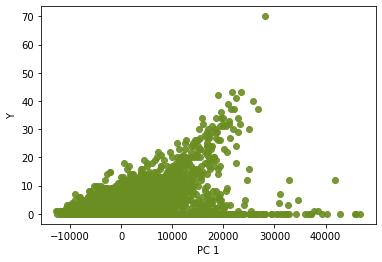

In [0]:
print('Explained variance ratio', pca_green_train.explained_variance_ratio_)
plt.scatter(projected_green_train, Y[:5841], alpha=0.9, color='olivedrab')
plt.xlabel('PC 1')
plt.ylabel( 'Y')

In [0]:
pca_blue_train = PCA(1, svd_solver='randomized')
projected_blue_train = pca_blue_train.fit_transform(np.reshape(X[:5841,:,:,2],(5841, 267*267)))

# saving to save time in the future
#np.save("projected_blue_train", projected_blue_train)

Explained variance ratio [0.27207578]


Text(0, 0.5, 'Y')

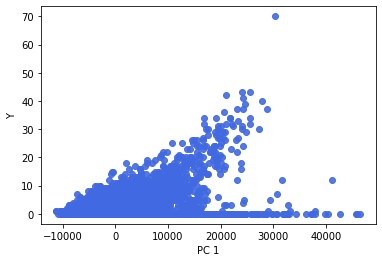

In [0]:
print('Explained variance ratio', pca_blue_train.explained_variance_ratio_)
plt.scatter(projected_blue_train, Y[:5841], alpha=0.9, color='royalblue')
plt.xlabel('PC 1')
plt.ylabel( 'Cell count')

In [0]:
pca_brown_train = PCA(1, svd_solver='randomized')
projected_brown_train = pca_brown_train.fit_transform(np.reshape(hed_data[:5841],(5841, 267*267)))

#np.save("projected_brown_train", projected_brown_train)

projected_brown_train [0.28582348]


Text(0, 0.5, 'Cell count')

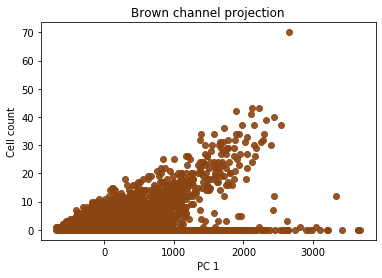

In [0]:
print("projected_brown_train", pca_brown_train.explained_variance_ratio_)
plt.scatter(projected_brown_train, Y[:5841], color = "saddlebrown", alpha = 0.9)
plt.title("Brown channel projection")
plt.xlabel('PC 1')
plt.ylabel( 'Cell count')

#### Test data

Extracting PCs for the test data.

In [0]:
pca_red_test = PCA(1, svd_solver='randomized')
projected_red_test = pca_red_test.fit_transform(np.reshape(X[5841:,:,:,0],(1563, 267*267)))

#np.save("projected_red_test", projected_red_test)
print( "Explained variance ratio:", pca_red_test.explained_variance_ratio_)

0.3317156777207945

In [0]:
pca_green_test = PCA(1, svd_solver='randomized')
projected_green_test = pca_green_test.fit_transform(np.reshape(X[5841:,:,:,1],(1563, 267*267)))

#np.save("projected_green_test", projected_green_test)
print( "Explained variance ratio:", pca_green_test.explained_variance_ratio_)

KeyboardInterrupt: 

In [0]:
pca_blue_test = PCA(1, svd_solver='randomized')
projected_blue_test = pca_blue_test.fit_transform(np.reshape(X[5841:,:,:,2],(1563, 267*267)))

np.save("projected_blue_test", projected_blue_test)
print( "Explained variance ratio:", pca_blue_test.explained_variance_ratio_)

Explained variance ratio: [0.35026185]


In [0]:
pca_brown_test = PCA(1, svd_solver='randomized')
projected_brown_test = pca_brown_test.fit_transform(np.reshape(hed_data[5841:,:,:],(1563, 267*267)))

#np.save("projected_brown_test", projected_brown_test)
print( "Explained variance ratio:", pca_brown_test.explained_variance_ratio_)

Explained variance ratio: [0.33994669]


### f. My own features

From what I see, when there is a higher concentration of cells (blue and brown), the simple "browness" can be inadequare because the brown cells in the picture vary in size. Thus, the feature does not capture the relative browness. To help with this issues, alongside the other  variables, I think it is worh including a  ratio of brown cells to blue cells. The blue cells can be extracted via Hematoxylin chanel. Then taking the ratio of the "browness" of the DAB channel to the "blueness" of the Hematoxylin chanel could help to separate brown cells from blue ones and also indirectly inform about the size of the brown cells. 

I begin by preprocessing the image and extracting Hematoxylin chanel.

In [0]:
# extracting Hematoxylin chanel
hed_blue = rgb2hed(X[:1000,:,:,:])[:,:,:,0]
hed_blue = (hed_blue * 128).astype("int8")

hed_blue_2 = rgb2hed(X[1000:2000])[:,:,:,0]
hed_blue_2 = (hed_blue_2 * 128).astype("int8")

hed_blue = np.vstack((hed_blue, hed_blue_2))

hed_blue_2 = rgb2hed(X[2000:3000])[:,:,:,0]
hed_blue_2 = (hed_blue_2 * 128).astype("int8")

hed_blue = np.vstack((hed_blue, hed_blue_2))

hed_blue_2 = rgb2hed(X[3000:4000])[:,:,:,0]
hed_blue_2 = (hed_blue_2 * 128).astype("int8")

hed_blue = np.vstack((hed_blue, hed_blue_2))

hed_blue_2 = rgb2hed(X[4000:5000])[:,:,:,0]
hed_blue_2 = (hed_blue_2 * 128).astype("int8")

hed_blue = np.vstack((hed_blue, hed_blue_2))

hed_blue_2 = rgb2hed(X[5000:6000])[:,:,:,0]
hed_blue_2 = (hed_blue_2 * 128).astype("int8")

hed_blue = np.vstack((hed_blue, hed_blue_2))

hed_blue_2 = rgb2hed(X[6000:])[:,:,:,0]
hed_blue_2 = (hed_blue_2 * 128).astype("int8")

hed_blue = np.vstack((hed_blue, hed_blue_2))
del(hed_blue_2)
#np.save("hed_blue", hed_blue)

In [0]:
# calculating the brown/blue ratio

ratio_brown_blue = []
for i in range(0,np.shape(hed_blue)[0]):
    ratio_brown_blue.append(np.mean(hed_data[i,:,:])/(np.mean(hed_blue[i,:,:])))
np.save("ratio_brown_blue", ratio_brown_blue)

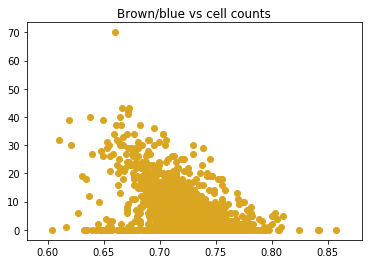

In [0]:
plt.scatter(ratio_brown_blue, Y, color = "goldenrod")
plt.title("Brown/blue vs cell counts")
plt.show()

In [0]:
print("Correlation between brown/blue and cell counts:", np.corrcoef(ratio_brown_blue, Y)[0,1])

Correlation between brown/blue and cell counts: -0.5367994671747104


It seems that this feature is a good predictor of the cell counts. It has in absolute terms higher than 50 correlation which is also supported by the scatter plot. Thus, the feature will be added to the regression among other variables.

In [0]:
difference_blue_brown = []
for i in range(0,np.shape(hed_blue)[0]):
    difference_blue_brown.append(np.mean(hed_blue[i,:,:] - (hed_data[i,:,:])))

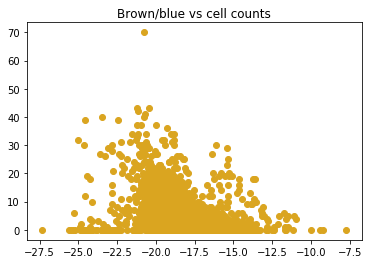

In [0]:
plt.scatter(difference_blue_brown, Y, color = "goldenrod")
plt.title("Brown/blue vs cell counts")
plt.show()

In [0]:
print("Correlation between brown/blue and cell counts:", np.corrcoef(difference_blue_brown, Y)[0,1])

Correlation between brown/blue and cell counts: -0.29261278849850236


## ii) Model implementation

I sart by constructing a feature matrix with all the selected features: brown to blue ratio, all average colors, blue and brown variance as well as entropy and first principal components of all the four channels. I have decided to use pandas so I could have a better look if all the data mergers I do work well.

In [0]:
features_train = pd.concat([pd.DataFrame(projected_brown_train), 
                            pd.DataFrame(projected_green_train)],axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(projected_red_train)], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(projected_blue_train)], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(average_red[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(average_blue[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(average_green[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(average_brown[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(ratio_brown_blue[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(variance_blue[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(variance_brown[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(entropy_blue[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(entropy_brown[:5841])], axis = 1)

features_train = features_train.to_numpy()

In [0]:
np.shape(features_train)

(5841, 13)

For some models such as Support Vector Machine and Ridge Regression it is best to standardize or normalize the data. This will be done later on.

### a. Linear Regression

Before starting modelling, the cross-validation strategy must be set. It is best that the training models will not be validated and tested on the same patients images since that might lead to model overperformance if it learns specific patterns of a specific patient. Thus, I have decided to manually create 3 folds: Fold 1 containing information from patients 1 to 4 (1935 cases), Fold 2 - patients from 5 to 10 (1949 cases) and Fold 3 - patients 11 to 13 (1957 cases). Consequently, the first training set will include Fold 2 and 3, second, fold 1 and 3 and third - fold 1 and 2. Leaving the remaining fold for validation.

In [0]:
# creating the function to split data into custom folds
def Folds(X, Y):
    val_1 = X[:1935]
    val_2 = X[1935:3884]
    val_3 = X[3884:]

    val = [val_1, val_2, val_3]

    val_1_labels = Y[:1935]
    val_2_labels = Y[1935:3884]
    val_3_labels = Y[3884:5841]

    val_labels = [val_1_labels, val_2_labels, val_3_labels]

    train_1 = np.vstack((val_2, val_3))
    train_2 = np.vstack((val_1, val_3))
    train_3 = np.vstack((val_1, val_2))

    train = [train_1, train_2, train_3]

    train_1_labels = np.hstack((val_2_labels, val_3_labels))
    train_2_labels = np.hstack((val_1_labels, val_3_labels))
    train_3_labels = np.hstack((val_1_labels, val_2_labels))

    train_labels = [train_1_labels, train_2_labels, train_3_labels]
    
    return train, train_labels, val, val_labels

In [0]:
train, train_lables, val, val_labels = Folds(features_train, Y)

Now we can run initial regression.

In [0]:
# creating lists to store the performance metrics
RMSE = []
R2 = []
MAE = []
CORR = []
for i in range(0,3):
    reg = sm.OLS(train_labels[i], train[i])
    results = reg.fit()
    
    # the bellow if condition saves the summary table for all the folds so I could check the coeficient
    # and their significance
    if i == 0:
        res_1 = results.summary()
    elif i == 1:
        res_2 = results.summary()
    elif i == 2:
        res_3 = results.summary()
        
    # Printing AIC score    
    print("AIC:", results.aic)
    
    # predictions on validation
    reg_predict = results.predict(val[i])
    MAE.append(mean_absolute_error(val_labels[i], reg_predict))
    RMSE.append(mean_squared_error(val_labels[i], reg_predict, squared = False))  
    R2.append(r2_score(val_labels[i], reg_predict))
    CORR.append(np.corrcoef(val_labels[i], reg_predict)[0,1])

AIC: 19060.07572257334
AIC: 17321.89690833281
AIC: 19300.38110575676


In [0]:
print(np.mean(RMSE), np.mean(MAE), np.mean(R2), np.mean(CORR))
#2.9331694208639347 1.6930118888161945 0.5804261698400879 0.7743612662418625

2.9331694208639347 1.6930118888161945 0.5804261698400879 0.7743612662418625


In [0]:
res_1
# looking into the summary of the all folds
# all variables are fairly significant. Will try to include more variables now.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.743
Model:                            OLS   Adj. R-squared (uncentered):              0.742
Method:                 Least Squares   F-statistic:                              935.9
Date:                Mon, 16 Mar 2020   Prob (F-statistic):                        0.00
Time:                        16:42:03   Log-Likelihood:                         -9518.0
No. Observations:                3906   AIC:                                  1.906e+04
Df Residuals:                    3894   BIC:                                  1.914e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2493      0.099      2.511      0.012       0.055       0.444
x2             0.0053      0.008      0.644      0.520      -0.011       0.021
x3             0.0061      0.000     15.201      0.000       0.005       0.007
x4            -0.0285      0.016     -1.787      0.074      -0.060       0.003
x5             0.6582      1.097      0.600      0.549      -1.492       2.809
x6            -5.3069      4.280     -1.240      0.215     -13.698       3.084
x7             0.6582      1.097      0.600      0.549      -1.492       2.809
x8           -56.4500     26.582     -2.124      0.034    -108.566      -4.334
x9          -521.2864     36.866    -14.140      0.000    -593.564    -449.009
x10           -0.0031      0.000    -13.486      0.000      -0.004      -0.003
x11            0.5449      0.040     13.629      0.000       0.467       0.623
x12           73.0409      3.994     18.287      0.000      65.210      80.872
x13         -217.5843     79.812     -2.726      0.006    -374.061     -61.107
==============================================================================
Omnibus:                     1570.186   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           156194.443
Skew:                           0.956   Prob(JB):                         0.00
Kurtosis:                      33.920   Cond. No.                     3.77e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.98e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

The initial regression yielded reasonable results, yet their quality is best to be examined in the light of another model. Looking into the summary tables of the all folds, green PC1 and average green seemed to be the most redundant variables, yet removing them did not improve the model based on AIC which means that the extra likelihood the variable gives fully balances out the penalty incurred with increasing model complexity. Hence I decided to keep the variables in. 


Seeing overall high significance of all the variables, I decided to put the before excluded variables in - green and red entropy as well as variance. The updated regression is shown bellow.

In [0]:
projected_brown_train = np.load("projected_brown_train.npy")
projected_green_train = np.load("projected_green_train.npy")
projected_red_train = np.load("projected_red_train.npy")
projected_blue_train = np.load("projected_blue_train.npy")
average_red = np.load("average_red.npy")
average_green = np.load("average_green.npy")
average_blue = np.load("average_blue.npy")
average_brown = np.load("average_brown.npy")
variance_red = np.load("variance_red.npy")
variance_blue = np.load("variance_blue.npy")
variance_green = np.load("variance_green.npy")
variance_brown = np.load("variance_brown.npy")
entropy_red = np.load("entropy_red.npy")
entropy_blue = np.load("entropy_blue.npy")
entropy_green = np.load("entropy_green.npy")
entropy_brown = np.load("entropy_brown.npy")
ratio_brown_blue = np.load("ratio_brown_blue.npy")

In [0]:
features_train = pd.concat([pd.DataFrame(features_train), pd.DataFrame(entropy_red[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(entropy_green[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(variance_red[:5841])], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(variance_green[:5841])], axis = 1)

features_train = features_train.to_numpy()
#np.save("features_train", features_train)

In [0]:
np.shape(features_train)

(5841, 17)

In [0]:
train, train_lables, val, val_labels = Folds(features_train, Y)

In [0]:
RMSE = []
R2 = []
MAE = []
CORR = []
for i in range(0,3):
    reg = sm.OLS(train_labels[i], train[i])
    results = reg.fit()
    
     # the bellow if condition saves the summary table for all the folds so I could check the coeficient
    # and their significance
    if i == 0:
        res_1 = results.summary()
    elif i == 1:
        res_2 = results.summary()
    elif i == 2:
        res_3 = results.summary()
        
    # Printing AIC score    
    print("AIC:", results.aic)

    # predictions on validation
    reg_predict = results.predict(val[i])
    MAE.append(mean_absolute_error(val_labels[i], reg_predict))
    RMSE.append(mean_squared_error(val_labels[i], reg_predict, squared = False))  
    R2.append(r2_score(val_labels[i], reg_predict))
    CORR.append(np.corrcoef(val_labels[i], reg_predict)[0,1])

AIC: 18459.94532338557
AIC: 16826.672173226245
AIC: 18737.607122904257


AIC scores fell meaning that the likelihood of the data was improved even after penalizing the model complexity. 

In [0]:
print(np.mean(RMSE), np.mean(MAE), np.mean(R2), np.mean(CORR))
# Much better. Look closer to coefficients
# 2.7572079025898013 1.6575799361650319 0.6314796468512487 0.8215365236103925

2.7572079025898013 1.6575799361650319 0.6314796468512487 0.8215365236103925


This model yielded better results meaning that the extra variables were informative. RMSE fell by roghly 0.18, MAE by 0.04, R2 increased by 5 percentage points and the correlation by approximatelly 4.5. 

Now I examine the individual variables.

In [0]:
res_3

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.762
Model:                            OLS   Adj. R-squared (uncentered):              0.761
Method:                 Least Squares   F-statistic:                              772.3
Date:                Mon, 16 Mar 2020   Prob (F-statistic):                        0.00
Time:                        16:42:47   Log-Likelihood:                         -9352.8
No. Observations:                3884   AIC:                                  1.874e+04
Df Residuals:                    3868   BIC:                                  1.884e+04
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2669      0.098      2.733      0.006       0.075       0.458
x2             0.0096      0.008      1.181      0.238      -0.006       0.026
x3             0.0082      0.001     15.770      0.000       0.007       0.009
x4            -0.0370      0.016     -2.340      0.019      -0.068      -0.006
x5             1.4295      1.090      1.311      0.190      -0.708       3.567
x6            -6.7408      4.225     -1.596      0.111     -15.024       1.542
x7             1.4295      1.090      1.311      0.190      -0.708       3.567
x8           -51.7673     26.103     -1.983      0.047    -102.944      -0.591
x9          -456.1492     65.178     -6.998      0.000    -583.936    -328.362
x10           -0.0181      0.001    -22.244      0.000      -0.020      -0.016
x11            1.3758      0.079     17.389      0.000       1.221       1.531
x12          -53.0589     17.972     -2.952      0.003     -88.294     -17.824
x13         -182.9384     78.263     -2.337      0.019    -336.379     -29.498
x14          -32.8207     12.780     -2.568      0.010     -57.877      -7.765
x15          139.6495     12.051     11.588      0.000     116.022     163.277
x16            0.0003      0.000      0.711      0.477      -0.001       0.001
x17            0.0087      0.000     19.116      0.000       0.008       0.010
==============================================================================
Omnibus:                     1487.476   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           190147.262
Skew:                           0.789   Prob(JB):                         0.00
Kurtosis:                      37.241   Cond. No.                     4.37e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.34e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

The significance of the variables are very sample dependent, thus I decided not to remove anything. I have also tried to add another feature I made - the difference between brown and blue - but it increased AIC and yielded worse validation performance measures. 

Another thing worth trying is to include quadratic terms of the Principal components variables. This is because looking at the PCs plots above, they all exhibit slightly quadratic shape, thus the quadratic components might help to employ the data better. 

In [0]:
# adding quadratic PC variables to the dataset
features_train = pd.concat([pd.DataFrame(features_train), pd.DataFrame(np.square(projected_brown_train[:5841]))], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(np.square(projected_red_train[:5841]))], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(np.square(projected_green_train[:5841]))], axis = 1)
features_train = pd.concat([features_train, pd.DataFrame(np.square(projected_blue_train[:5841]))], axis = 1)

features_train = features_train.to_numpy()

In [0]:
train, train_lables, val, val_labels = Folds(features_train, Y)

In [0]:
# Running the model again
RMSE = []
R2 = []
MAE = []
CORR = []
for i in range(0,3):
    reg = sm.OLS(train_labels[i], train[i])
    results = reg.fit()
    
     # the bellow if condition saves the summary table for all the folds so I could check the coeficient
    # and their significance
    if i == 0:
        res_1 = results.summary()
    elif i == 1:
        res_2 = results.summary()
    elif i == 2:
        res_3 = results.summary()
        
    # Printing AIC score    
    print("AIC:", results.aic)

    # predictions on validation
    reg_predict = results.predict(val[i])
    MAE.append(mean_absolute_error(val_labels[i], reg_predict))
    RMSE.append(mean_squared_error(val_labels[i], reg_predict, squared = False))  
    R2.append(r2_score(val_labels[i], reg_predict))
    CORR.append(np.corrcoef(val_labels[i], reg_predict)[0,1])
# AIC is better    

AIC: 18394.36721979138
AIC: 16572.04416547899
AIC: 18592.10297627245


In [0]:
print(np.mean(RMSE), np.mean(MAE), np.mean(R2), np.mean(CORR))
# Worse that without quadratic terms
#2.8209688198448384 1.698517745028223 0.6148451243730045 0.8080388172594265

2.8209688198448384 1.698517745028223 0.6148451243730045 0.8080388172594265


Even though the quadratic variables improved AIC meaning that they increased the likelihood, the validation performance metrics appeared to be worse. This signals that the quadratic variables help to fit the model to the data better yet results in some degree of overfitting. Thus, for the testing, I have decided to use the data wihout these quadratic terms. 

Note, I have also tried standardizing and normalizing the data, yet the results appeared to be worse. \Thus saving our time and space, I did not include this in the analysis

#### Testing OLS

First, I will remove the quadratic terms from the train data, construct the test feature matrix, train the model on the whole data and generate predictions.

In [0]:
# removing quadratic terms
features_train = features_train[:,:17]
np.shape(features_train)

(5841, 17)

In [0]:
projected_brown_test = np.load("projected_brown_test.npy")
projected_green_test = np.load("projected_green_test.npy")
projected_red_test = np.load("projected_red_test.npy")
projected_blue_test = np.load("projected_blue_test.npy")
average_red = np.load("average_red.npy")
average_green = np.load("average_green.npy")
average_blue = np.load("average_blue.npy")
average_brown = np.load("average_brown.npy")
variance_red = np.load("variance_red.npy")
variance_blue = np.load("variance_blue.npy")
variance_green = np.load("variance_green.npy")
variance_brown = np.load("variance_brown.npy")
entropy_red = np.load("entropy_red.npy")
entropy_blue = np.load("entropy_blue.npy")
entropy_green = np.load("entropy_green.npy")
entropy_brown = np.load("entropy_brown.npy")
ratio_brown_blue = np.load("ratio_brown_blue.npy")

In [0]:
# Creating testing data
features_test = pd.concat([pd.DataFrame(projected_brown_test), 
                            pd.DataFrame(projected_green_test)],axis = 1)
features_test = pd.concat([features_test, pd.DataFrame(projected_red_test)], axis = 1)
features_test = pd.concat([features_test, pd.DataFrame(projected_blue_test)], axis = 1)
features_test = pd.concat([features_test, pd.DataFrame(average_red[5841:])], axis = 1)
features_test = pd.concat([features_test, pd.DataFrame(average_blue[5841:])], axis = 1)
features_test = pd.concat([features_test, pd.DataFrame(average_green[5841:])], axis = 1)
features_test = pd.concat([features_test, pd.DataFrame(average_brown[5841:])], axis = 1)
features_test = pd.concat([features_test, pd.DataFrame(ratio_brown_blue[5841:])], axis = 1)
features_test = pd.concat([features_test, pd.DataFrame(variance_blue[5841:])], axis = 1)
features_test = pd.concat([features_test, pd.DataFrame(variance_brown[5841:])], axis = 1)
features_test = pd.concat([features_test, pd.DataFrame(entropy_blue[5841:])], axis = 1)
features_test = pd.concat([features_test, pd.DataFrame(entropy_brown[5841:])], axis = 1)
features_test = pd.concat([features_test, pd.DataFrame(entropy_red[5841:])], axis = 1)
features_test = pd.concat([features_test, pd.DataFrame(entropy_green[5841:])], axis = 1)
features_test = pd.concat([features_test, pd.DataFrame(variance_red[5841:])], axis = 1)
features_test = pd.concat([features_test, pd.DataFrame(variance_green[5841:])], axis = 1)

features_test = features_test.to_numpy()
np.save("features_test", features_test)

In [0]:
np.shape(features_test)

(1563, 17)

In [0]:
# training OLS based on the full training data
reg_train = sm.OLS(Y[:5841], features_train)
results = reg_train.fit()
# predicting based on the testing data
reg_predict_test = results.predict(features_test) 
print("AIC:", results.aic)

AIC: 27316.23439274345


In [0]:
print(mean_squared_error(Y[5841:], reg_predict_test, squared = False),
      mean_absolute_error(Y[5841:], reg_predict_test),
     r2_score(Y[5841:], reg_predict_test),
     np.corrcoef(Y[5841:], reg_predict_test)[0,1])
# 3.6321302340746455 2.4808952342908497 0.4973112815376206 0.7918757588486353

3.6321302340746455 2.4808952342908497 0.4973112815376206 0.7918757588486353


Text(0, 0.5, 'Residuals')

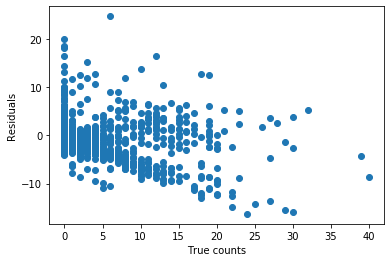

In [0]:
# true against residuals plot
plt.scatter(Y[5841:], (reg_predict_test - Y[5841:]) )
plt.xlabel("True counts")
plt.ylabel("Residuals")

Overall, the performance is worse than in the validation data. From the scatter plot we can see that the biggest issue is with the zero counts as well as large counts. Whilst zero true counts are being overestimated, the large counts are being underestimated. Looking closer into the predicted counts data, we can see that the model predicts negative counts for some observations. This is a big limitation of OLS and we better focus on the models which can prevent negative predictions from happening.

### Multilayer perceptron

In [0]:
from __future__ import absolute_import, division, print_function
import os
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.python.keras import backend as K

from keras.constraints import max_norm
from keras import regularizers

tf.__version__


'2.1.0'

I have started with a multilayer perceptron having 2 hidden layers with a sigmoid activation function and linear outer layer. I then compared the performance with relu and relu proved to be a superior network for this problem. I tried a few reguliarization methods - max norm, dropouts, batch normalization, L2 reguliarization. Since this MLP is a relativelly small network, some of these reguliarization methods resulted into the over-reguliarization when the loss of the training data was consistently above that of validation. I thus relaxed reguliarization and stayed with L2 reguliarization only. 

I started running the network for 800 epoches and observed that the epoch period where all of the folds perform the best is around the 100th epoch. At the epoch 150 some of the folds indicated validation set divergence. The loss function graphs are available bellow the MLP. 

In [0]:
train, train_lables, val, val_labels = Folds(features_train, Y)

In [0]:
np.shape(features_train)

(5841, 17)

In [0]:
# model 3 - reLU model for 800 epochs

model3 = Sequential()
model3.add(Dense(13,input_dim=np.shape(features_train)[1],
                 kernel_initializer = 'uniform', activation='relu', 
                 kernel_regularizer=regularizers.l2(0.1)))
model3.add(Dense(8,kernel_initializer = 'uniform', activation='relu', 
                 kernel_regularizer=regularizers.l2(0.1)))
model3.add(Dense(4, kernel_initializer = 'uniform', activation='relu',
                kernel_regularizer=regularizers.l2(0.1)))
model3.add(Dense(1,kernel_initializer = 'uniform', activation='relu'))
model3.compile(loss = 'MSE',optimizer='adam',metrics=['MAE'])

# using the same train/validation folds as in the OLS.
for i in range(0,3):
  if i == 0:
    # creating checkpointer to store the results
    checkpoint_path = "training_1/3rd_model_1.ckpt" 
    checkpoint_dir = os.path.dirname(checkpoint_path)  
    cp_model3 = ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only = True,
                                monitor = 'val_loss')
    history3_1 = model3.fit(train[i],train_labels[i], nb_epoch = 800, 
             batch_size = 32, callbacks = [cp_model3],
             validation_data = (val[i], val_labels[i]))
  elif i == 1:
    # creating checkpointer to store the results
    checkpoint_path = "training_1/3rd_model_2.ckpt"
    heckpoint_dir = os.path.dirname(checkpoint_path)  
    cp_model3 = ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only = True,
                                monitor = 'val_loss')
    history3_2 = model3.fit(train[i], train_labels[i], nb_epoch = 800, 
             batch_size = 32, callbacks = [cp_model3],
             validation_data = (val[i], val_labels[i]))
  elif i == 2:
    # creating checkpointer to store the results
    checkpoint_path = "training_1/3rd_model_3.ckpt"
    heckpoint_dir = os.path.dirname(checkpoint_path)  
    cp_model3 = ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only = True,
                                monitor = 'val_loss')
    history3_3 = model3.fit(train[i],train_labels[i], nb_epoch = 800, 
             batch_size = 32, callbacks = [cp_model3],
             validation_data = (val[i], val_labels[i]))

In [0]:
# plotting validation vs testing loss function for the first fold
plt.plot(history3_1.history['loss'][:])
plt.plot(history3_1.history['val_loss'][:])

In [0]:
# plotting validation vs testing loss function for the second fold
plt.plot(history3_2.history['loss'][:])
plt.plot(history3_2.history['val_loss'][:])

In [0]:
# plotting validation vs testing loss function for the third fold
plt.plot(history3_3.history['loss'][:])
plt.plot(history3_3.history['val_loss'][:])

Bellow, I will be running the network for 100 epochs for each fold. I have chosen a batch size of 36 because smaller batch sizes resulted in a severe fluctations of the loss curves which made it difficult to spot convergence and divergence. 

In addition, since the neural networks are stochastic, I ran the same neural networks a few times to get a better look into the average performance of the model on the validation set. 

In [0]:
# reruning the network with 75 epochs
model3 = Sequential()
model3.add(Dense(13,input_dim=np.shape(features_train)[1],
                 kernel_initializer = 'uniform', activation='relu', 
                 kernel_regularizer=regularizers.l2(0.2)))
model3.add(Dense(8,kernel_initializer = 'uniform', activation='relu', 
                 kernel_regularizer=regularizers.l2(0.2)))
model3.add(Dense(4, kernel_initializer = 'uniform', activation='relu',
                kernel_regularizer=regularizers.l2(0.2)))
model3.add(Dense(1,kernel_initializer = 'uniform', activation='relu'))
model3.compile(loss = 'MSE',optimizer='adam',metrics=['MAE'])

# creating lists to save validation results.
RMSE_m3 = []
MAE_m3 = []
R2_m3 = []
CORR_m3 = []

# using the same train/validation folds as in the OLS.
for i in range(0,3):
  if i == 0:
    # creating checkpointer to store the results
    checkpoint_path = "training_1/3rd_model_1.ckpt" 
    checkpoint_dir = os.path.dirname(checkpoint_path)  
    cp_model3 = ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only = True, 
                                monitor = 'val_loss')
    history3_1 = model3.fit(train[i],train_labels[i], nb_epoch = 75, 
             batch_size = 32, callbacks = [cp_model3],
             validation_data = (val[i], val_labels[i]))
  elif i == 1:
    # creating checkpointer to store the results
    checkpoint_path = "training_1/3rd_model_2.ckpt"
    heckpoint_dir = os.path.dirname(checkpoint_path)  
    cp_model3 = ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only = True,
                                monitor = 'val_loss')
    history3_2 = model3.fit(train[i], train_labels[i], nb_epoch = 75, 
             batch_size = 32, callbacks = [cp_model3],
             validation_data = (val[i], val_labels[i]))
  elif i == 2:
    # creating checkpointer to store the results
    checkpoint_path = "training_1/3rd_model_3.ckpt"
    heckpoint_dir = os.path.dirname(checkpoint_path)  
    cp_model3 = ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only = True,
                                monitor = 'val_loss')
    history3_3 = model3.fit(train[i],train_labels[i], nb_epoch = 75, 
             batch_size = 32, callbacks = [cp_model3],
             validation_data = (val[i], val_labels[i]))

  # getting validation predictions based on the last epochs weights for each fold
  predicted = model3.predict(val[i])
  RMSE_m3.append(mean_squared_error(val_labels[i], predicted, squared= False))   
  MAE_m3.append(mean_absolute_error(val_labels[i], predicted))
  R2_m3.append(r2_score(val_labels[i], predicted))  
  CORR_m3.append(np.corrcoef(val_labels[i], np.reshape(predicted, (1, np.shape(predicted)[0])))[0,1])

Train on 3906 samples, validate on 1935 samples
Epoch 1/75
3392/3906 [=========================>....] - ETA: 0s - loss: 29.8505 - MAE: 2.9372
Epoch 00001: saving model to training_1/3rd_model_1.ckpt
3906/3906 [==============================] - 1s 232us/sample - loss: 29.3243 - MAE: 2.9149 - val_loss: 27.9829 - val_MAE: 2.8462
Epoch 2/75
3456/3906 [=========================>....] - ETA: 0s - loss: 26.2385 - MAE: 2.5547
Epoch 00002: saving model to training_1/3rd_model_1.ckpt
3906/3906 [==============================] - 0s 82us/sample - loss: 25.5779 - MAE: 2.5307 - val_loss: 20.5623 - val_MAE: 2.5391
Epoch 3/75
3040/3906 [======================>.......] - ETA: 0s - loss: 19.8305 - MAE: 2.4952
Epoch 00003: saving model to training_1/3rd_model_1.ckpt
3906/3906 [==============================] - 0s 87us/sample - loss: 20.3766 - MAE: 2.5132 - val_loss: 18.4317 - val_MAE: 2.5367
Epoch 4/75
3296/3906 [========================>.....] - ETA: 0s - loss: 18.5878 - MAE: 2.4821
Epoch 00004: saving 

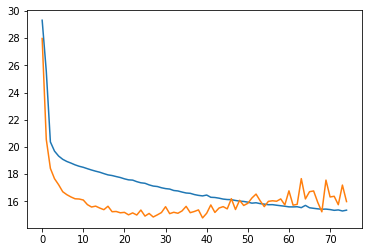

In [0]:
# plotting validation vs testing loss function for the first fold
plt.plot(history3_1.history['loss'][:])
plt.plot(history3_1.history['val_loss'][:])

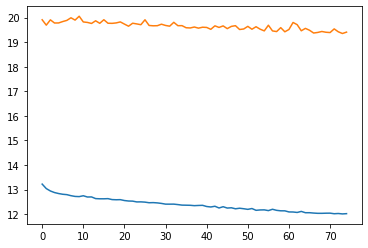

In [0]:
# plotting validation vs testing loss function for the second fold
plt.plot(history3_2.history['loss'][:])
plt.plot(history3_2.history['val_loss'][:])

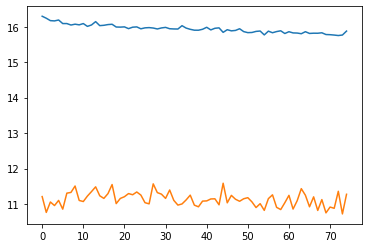

In [0]:
# plotting validation vs testing loss function for the third fold
plt.plot(history3_3.history['loss'][:])
plt.plot(history3_3.history['val_loss'][:])
# this folds must be easy, because for this fold only validation and testing loss curves overlap a lot.

The first fold indicates the most examplary convergence whilst the second and third folda do not indicate a lot of learning. Looking into the graphs I believe this is the case because even with the initial weights, the networks generates a relativelly low error (training RMSE of around 2 for both folds).

In [0]:
print(np.mean(RMSE_m3), np.mean(MAE_m3), np.mean(R2_m3), np.mean(CORR_m3))
# 2.1172133658446635 1.2915113479135718 0.7830972462622489 0.903676662830499
# 2.3457736022487086 1.3180716636798533 0.7338328328520358 0.9037902169727009
# 2.2288565923384525 1.328360226411506 0.7590707704849037 0.889299498439024
# 2.187175198949318 1.2835205534735499 0.7689058972416781 0.9049475681762745
# 2.211907197845717 1.2558989847302595 0.7626782847831078 0.8797238643792414

2.7901291810005078 1.617620193117575 0.6212687117211839 0.8103402977769619


In [0]:
m3_summary = np.array(
[[2.1172133658446635, 1.2915113479135718, 0.7830972462622489, 0.903676662830499],
[2.3457736022487086, 1.3180716636798533, 0.7338328328520358, 0.9037902169727009],
[2.2288565923384525, 1.328360226411506, 0.7590707704849037, 0.889299498439024],
[2.187175198949318, 1.2835205534735499, 0.7689058972416781, 0.9049475681762745],
[2.211907197845717, 1.2558989847302595, 0.7626782847831078, 0.8797238643792414]])

In [0]:
print("RMSE:", np.mean(m3_summary[:,0]), "MAE:", np.mean(m3_summary[:,1]), 
      "R2:", np.mean(m3_summary[:,2]), "Correlation", np.mean(m3_summary[:,3]))
#RMSE: 2.2181851914453716 MAE: 1.295472555241748 R2: 0.7615170063247949 Correlation 0.896287562159548

print("RMSE variance:", np.var(m3_summary[:,0]), "MAE variance:", np.var(m3_summary[:,1]), 
      "R2 variance:", np.var(m3_summary[:,2]), "Correlation variance", np.var(m3_summary[:,3]))
#RMSE: 0.005517804754344872 MAE: 0.0006633855219917861 R2: 0.0002588097126103219 
# Correlation 0.00010181469217999004

RMSE: 2.2181851914453716 MAE: 1.295472555241748 R2: 0.7615170063247949 Correlation 0.896287562159548
RMSE variance: 0.005517804754344872 MAE variance: 0.0006633855219917861 R2 variance: 0.0002588097126103219 Correlation variance 0.00010181469217999004


Multilayer Perceptron definintelly outperforms OLS at least on the validation set. RMSE decreased by on average 0.54, MAE fell by 0.35, R2 increased by 13 percentage points and correlation - by roughly 6. Variance remains relativelly low and build confidence in the results. 

Note, I have also tried to standardize and normalize the data for the MLP but the results appeared to be worse. For the same reason as before - saving your and my time - I will not include the analysis of the preprocessed data.


Now, we need to see MLPs testing performance.

#### Testing MLP

In [0]:
model3 = Sequential()
model3.add(Dense(13,input_dim=np.shape(features_train)[1],
                 kernel_initializer = 'uniform', activation='relu', 
                 kernel_regularizer=regularizers.l2(0.2)))
model3.add(Dense(8,kernel_initializer = 'uniform', activation='relu', 
                 kernel_regularizer=regularizers.l2(0.2)))
model3.add(Dense(4, kernel_initializer = 'uniform', activation='relu',
                kernel_regularizer=regularizers.l2(0.2)))
model3.add(Dense(1,kernel_initializer = 'uniform', activation='relu'))
model3.compile(loss = 'MSE',optimizer='adam',metrics=['MAE'])


checkpoint_path = "training_1/final_MLP.ckpt"

checkpoint_dir = os.path.dirname(checkpoint_path)  
cp_model3 = ModelCheckpoint(checkpoint_path, save_weights_only=True,  verbose=1,
                              monitor = 'MSE')
history_test = model3.fit(features_train,Y[:5841], nb_epoch = 75, batch_size = 32, 
                          callbacks = [cp_model3])

Train on 5841 samples
Epoch 1/75
5728/5841 [============================>.] - ETA: 0s - loss: 19.7820 - MAE: 2.4523
Epoch 00001: saving model to training_1/final_MLP.ckpt
5841/5841 [==============================] - 1s 146us/sample - loss: 19.6485 - MAE: 2.4453
Epoch 2/75
4960/5841 [========================>.....] - ETA: 0s - loss: 16.1222 - MAE: 2.1702
Epoch 00002: saving model to training_1/final_MLP.ckpt
5841/5841 [==============================] - 0s 72us/sample - loss: 16.0541 - MAE: 2.1654
Epoch 3/75
5760/5841 [============================>.] - ETA: 0s - loss: 11.1425 - MAE: 1.7925
Epoch 00003: saving model to training_1/final_MLP.ckpt
5841/5841 [==============================] - 0s 67us/sample - loss: 11.0589 - MAE: 1.7896
Epoch 4/75
5664/5841 [============================>.] - ETA: 0s - loss: 9.7445 - MAE: 1.6524 
Epoch 00004: saving model to training_1/final_MLP.ckpt
5841/5841 [==============================] - 0s 66us/sample - loss: 9.6778 - MAE: 1.6511
Epoch 5/75
5536/5841 [

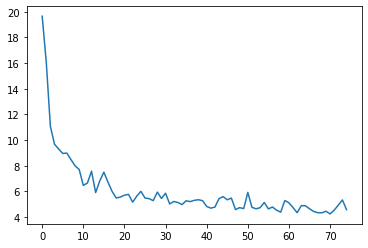

In [0]:
# plotting training loss function
plt.plot(history_test.history['loss'])
# steady and reasuring convergence. 

In [0]:
# predicting based on the training set
predictions_test = model3.predict(features_test)

print(mean_squared_error(Y[5841:], predictions_test, squared = False),
      mean_absolute_error(Y[5841:], predictions_test),
     r2_score(Y[5841:], predictions_test),
     np.corrcoef(Y[5841:], np.reshape(predictions_test, (1, np.shape(predictions_test)[0])))[0,1])

# 2.793675513173163 1.5129327842690437 0.7026087155700258 0.871418847587918
# 3.427519014833241 1.7759983629579355 0.552352606740016 0.8633679786841554
# 3.062366572179886 1.4699616663667991 0.6426525681907675 0.8166421034465382
# 2.5585100544746733 1.3138682874097172 0.7505689182107715 0.8729442988790264
# 2.6537127813265626 1.4068319093166677 0.731660783979263 0.8628779305872942

2.6537127813265626 1.4068319093166677 0.731660783979263 0.8628779305872942


In [0]:
m3_test_summary = np.array(
[[2.793675513173163, 1.5129327842690437, 0.7026087155700258, 0.871418847587918],
[3.427519014833241, 1.7759983629579355, 0.552352606740016, 0.8633679786841554],
[3.062366572179886, 1.4699616663667991, 0.6426525681907675, 0.8166421034465382],
[2.5585100544746733, 1.3138682874097172, 0.7505689182107715, 0.8729442988790264],
[2.6537127813265626, 1.4068319093166677, 0.731660783979263, 0.8628779305872942]])

In [0]:
print("RMSE:", np.mean(m3_test_summary[:,0]), "MAE:", np.mean(m3_test_summary[:,1]), 
      "R2:", np.mean(m3_test_summary[:,2]), "Correlation", np.mean(m3_test_summary[:,3]))
# RMSE: 2.8991567871975055 MAE: 1.4959186020640325 R2: 0.6759687185381688 Correlation 0.8574502318369864

print("RMSE variance:", np.var(m3_test_summary[:,0]), "MAE variance:", np.var(m3_test_summary[:,1]), 
      "R2 variance:", np.var(m3_test_summary[:,2]), "Correlation variance:", np.var(m3_test_summary[:,3]))
#RMSE variance: 0.09864266664174126 MAE variance: 0.024097334651936017 
#R2 variance: 0.005153478871241747 Correlation variance: 0.0004329942647405958

RMSE: 2.8991567871975055 MAE: 1.4959186020640325 R2: 0.6759687185381688 Correlation 0.8574502318369864
RMSE variance: 0.09864266664174126 MAE variance: 0.024097334651936017 R2 variance: 0.005153478871241747 Correlation variance: 0.0004329942647405958


In testing data, MLP performs noticeably better than OLS. RMSE fell by 0.74, MAE fell by approximatellt 1, R2 rose by 18 percentage points and correlation rose by approximatelly 6 points. It is therefore sure, that MLP exploits the information from the extracted features much more efficiently than OLS. 

Nonetheless, MLP still makes error which is on average equal to 1.5 counts (MAE). Whilst it is not a lot, it is good to examine which parts the network find especially difficult. To do this, I plot residual versus true counts scatter plot bellow.

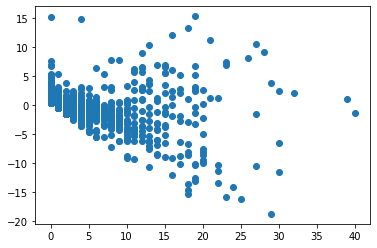

In [0]:
# true counts vs residuals plot
plt.scatter(Y[5841:], (np.reshape(predictions_test, (1, np.shape(predictions_test)[0])) - Y[5841:]))

Compared to OLS, MLP deals much better with the zero counts data. This is because the model never predicts negative counts (due to the ReLU activation function which sets all negative values to zero). Overall, MLP works especially well for low to mid-range cell counts - the error is the smallest for the 0-10 cell count data. OLS stuggled with low to mid-range counts too. Unfortunatelly, as with OLS, MLP struggles to accuratelly count the high cell data. From the scatter plot above, it seems that the model tends to underestimate the number of cells for the high count data. This suggests that we need to extract features which are characteristic to the high cell count data. Better examination of the images or CNN could help with this issue. 

### Ridge Regression

Ridge regression requires optimizing for the alpha parameters. Since I have custom folds, I will not use sklearn GridSearch but instead write my own Grid Search to incorporate my custom folds. 

In [0]:
# setting the parameter spaxe
parameters_ridge = [0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# empty lis to incorporate the mean values across all three folds.
MSE_ridge = []

for a in parameters_ridge:
    # calling ridge regression
    ridge = Ridge(a)
    # list to hold RMSE scores of each fold - overritten each "alpha" loop
    MSE_temp = []
    # loop against the 3 folds
    for i in range(0,3):
        ridge.fit(train[i], train_labels[i])
        pred = ridge.predict(val[i])
        MSE_temp.append(mean_squared_error(val_labels[i], pred, squared = False))
    # getting the mean accross all folds for each alpha parameter    
    MSE_ridge.append(np.mean(MSE_temp))
        

In [0]:
MSE_ridge

[2.790438900540673,
 2.806034842289421,
 2.818195033031286,
 2.8292576238198754,
 2.839714097816644,
 2.8497002958071023,
 2.8592603899857747,
 2.868413182485213,
 2.87717145627245,
 2.8855477269676033]

It seems that alpha of 0.1 gives the highest validation performance inidcating that less reguliarization is preffered. The RMSE score of 2.79 slightly lower than the validation score achieved by OLS but this is expected due to the reguliarization. 

Ridge regression might benefit from the preprocessing and thus bellow I a exploring the effects of standardization and normalization.

In [0]:
features_norm = preprocessing.normalize(features_train, norm="l2")
train, train_lables, val, val_labels = Folds(features_norm, Y)

In [0]:
# setting the parameter space
parameters_ridge = [0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# empty lis to incorporate the mean values across all three folds.
MSE_ridge = []

for a in parameters_ridge:
    # calling ridge regression
    ridge = Ridge(a)
    # list to hold RMSE scores of each fold - overritten each "alpha" loop
    MSE_temp = []
    # loop against the 3 folds
    for i in range(0,3):
        ridge.fit(train[i], train_labels[i])
        pred = ridge.predict(val[i])
        MSE_temp.append(mean_squared_error(val_labels[i], pred, squared = False))
    # getting the mean accross all folds for each alpha parameter    
    MSE_ridge.append(np.mean(MSE_temp))        

In [0]:
MSE_ridge

[3.8152575457855895,
 3.818920281057658,
 3.820309376075102,
 3.8212454631010773,
 3.822039961384579,
 3.8227918891215302,
 3.8235413030117904,
 3.824305160103536,
 3.8250897658472134,
 3.8258961849345408]

Reaults with the normalized data are worse than with un-processed data.

In [0]:
scaler = preprocessing.StandardScaler()
features_scale = scaler.fit_transform(features_train)
train, train_lables, val, val_labels = Folds(features_scale, Y)

In [0]:
# setting the parameter space
parameters_ridge = [0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# empty lis to incorporate the mean values across all three folds.
RMSE_ridge = []

for a in parameters_ridge:
    # calling ridge regression
    ridge = Ridge(a)
    # list to hold RMSE scores of each fold - overritten each "alpha" loop
    MSE_temp = []
    # loop against the 3 folds
    for i in range(0,3):
        ridge.fit(train[i], train_labels[i])
        pred = ridge.predict(val[i])
        RMSE_temp.append(mean_squared_error(val_labels[i], pred, squared = False))
    # getting the mean accross all folds for each alpha parameter    
    MSE_ridge.append(np.mean(MSE_temp))
        

In [0]:
MSE_ridge

[2.9055639249364593,
 2.936828648744438,
 2.954040982280276,
 2.9647723050634,
 2.9720368573728826,
 2.977248847673577,
 2.9811527978686976,
 2.9841754860966603,
 2.9865780573464975,
 2.9885287620633054]

The results using standardized data are better than using normalized data, yet worse than using un-processed data. Thus, for the ridge regression, I have decided to use the un-processed data with alpha = 0.1.

#### Testing Ridge Regression

In [0]:
ridge_test = Ridge(alpha = 0.1).fit(features_train, Y[:5841])

In [0]:
print(ridge_test.coef_)

[ 9.79688684e-02 -1.96171158e-03  4.77012233e-03 -8.30351761e-03
 -1.49813291e-01  3.33621829e-01 -1.49813291e-01 -3.30182094e+00
 -1.73253388e+01 -2.03811878e-02  1.72797941e+00 -7.19112176e+00
 -1.45121671e+00  2.45766807e+01  5.99713552e+01  1.57262782e-03
  8.26622687e-03]


In [0]:
ridge_predict = ridge_test.predict(features_test)

In [0]:
print(mean_squared_error(Y[5841:], ridge_predict, squared = False),
      mean_absolute_error(Y[5841:], ridge_predict),
     r2_score(Y[5841:], ridge_predict),
      np.corrcoef(Y[5841:], ridge_predict)[0,1])
# 3.4012135186715127 1.9910601414634652 0.5591974406526532 0.7993465861579692

3.4012135186715127 1.9910601414634652 0.5591974406526532 0.7993465861579692


First of all, Ridge regression yielded inferior results to MLP. When it comes to OLS, the reguliarization did manage to improve the results slightly. RMSE fell by 0.23, MAE fell by roughly 0.49, R2 rose by approximatelly 6 percentage points whilst the correlation rose by a marginal 0.008. 

In [0]:
plt.scatter(Y[5841:], (ridge_predict - Y[5841:]))
plt.show()

From the true counts vs predicted scatter plot, we can see that the model tends to underestimate the number of counts and deals with the zero counts worse than MLP. Thus MLP so far stands as the best model.

### Support Vector Regression

Support Vector Regression has a few parameters which need to be tuned in. For this reason I will empoly Grid Search. However, since I have custom training and testing folds, I will write a barebones Grid Search to incorporate my folds. Furthermore, Support Vector Regression (especially RBF kernel and linear models with L2, L1 losses) usually assumes that all features are standardized. Thus, I will preprocess the data in two different way for the SVR model analysis -  either normalize it or standardize it. I will start from analysing linear kernel followed by polynomial and RBF kernels.

Starting from the linear SVR, I am using LinearSVR due to it being more efficient than the standard SVR from sklearn library. In addition, since the data has a higher number of observations then features, I set the algorith to solve a primal optimization problem. Consequently, I opt for L2 loss. 

I first start with standardized data and then try normalized data (it is not centered around zero but in practice works well). The Linear SVR with non-preprocessed data did not converge even after adjusting the tolerance and maximum iteration, thus I will not be reporting it.

In [0]:
# getting standardized folds again
train, train_lables, val, val_labels = Folds(features_scale, Y)

In [0]:
# setting the parameter space for linear kernel
C_param = [0.1, 1, 10, 100, 1000]
epsilon_param = [0.5, 1, 2]

# empty lis to incorporate the mean values across all three folds.
SVR_linear = []

# Focus on linear kernel only. 

# loop over C parameter
for c in C_param:
    for e in epsilon_param:
    # list to hold individual for RMSE values
        RMSE_temp = []
        # loop over the three folds defined above. 
        for i in range(0,3):
            svr = LinearSVR(C = c, epsilon = e, dual = False, loss = 'squared_epsilon_insensitive')
            svr.fit(train[i], train_labels[i])
            # predict based on validation
            pred = svr.predict(val[i])
            # calculate RMSE of the validation fold
            RMSE_temp.append(mean_squared_error(val_labels[i], pred, squared = False))
        # take the average RMSE over all three validation folds.     
        SVR_linear.append(np.mean(RMSE_temp))

In [0]:
# Result for SVR with a linear kernel. 
SVR_linear

[2.987104720484742,
 2.974205103413605,
 2.9939030930606454,
 3.1061581565609218,
 2.96688107757847,
 2.969439637232694,
 3.031423593601147,
 3.157590644293292,
 2.8992686760412716,
 2.950598255255383,
 3.0718144967587375,
 3.245337021608325,
 2.8554154527548405,
 2.9322423460925138,
 3.0887874928425862,
 3.2764968014764086,
 2.870030246588714,
 2.9073190736271264,
 3.077463416127879,
 3.284682422299834]

In [0]:
# getting normalized folds again
train, train_lables, val, val_labels = Folds(features_norm, Y)

In [0]:
# setting the parameter space for linear kernel
C_param = [0.1, 1, 10, 100 , 1000]
epsilon_param = [0.5, 1, 2]

# empty lis to incorporate the mean values across all three folds.
SVR_linear = []

# Focus on linear kernel only. 

# loop over C parameter
for c in C_param:
    for e in epsilon_param:
    # list to hold individual for RMSE values
        RMSE_temp = []
        # loop over the three folds defined above. 
        for i in range(0,3):
            svr = LinearSVR(C = c, epsilon = e, dual = False, loss = 'squared_epsilon_insensitive')
            svr.fit(train[i], train_labels[i])
            # predict based on validation
            pred = svr.predict(val[i])
            # calculate RMSE of the validation fold
            RMSE_temp.append(mean_squared_error(val_labels[i], pred, squared = False))
        # take the average RMSE over all three validation folds.     
        SVR_linear.append(np.mean(RMSE_temp))

In [0]:
SVR_linear

[3.865265365393931,
 3.880329452037817,
 3.9380536222220077,
 4.036047645926023,
 3.833486602875244,
 3.85526766009227,
 3.93504487159859,
 4.0643250298780815,
 3.8199499397382595,
 3.8440994103697688,
 3.9360366143052676,
 4.082675089781033,
 3.708439725067443,
 3.743424907166807,
 3.857685500926054,
 4.036612737981229,
 3.5158299295403026,
 3.5477258036055637,
 3.67115135823323,
 3.8676394787167276]

As expected, the standardized data works better in the linear SVR case. The lowest result of 2.855 with the standardized data was achieved with C = 100 and epsilon 0.5. Normalized data, in turn, yielded the lowest score of 3.708. I will thus from now on focus on the standardized data only.

Now, I will test the polynomial kernel.

In [0]:
# getting standardized folds again
train, train_lables, val, val_labels = Folds(features_scale, Y)

In [0]:
# setting the parameter space for the polynomial SVR
C_param = [ 0.01, 0.1, 1, 10, 100]
degree_param = [2,3]
epsilon_param = [0.5, 1, 2]

# empty lis to incorporate the mean values across all three folds.
SVR_poly = []

# Focus on polynomial kernel

# loop over the degrees of polynomial -  starting with 2 and 3
for d in degree_param:
    # loop over C parameter
    for c in C_param:
        # loop over epsilon
        for e in epsilon_param:
            # list to hold individual for RMSE values
            RMSE_temp = []
            for i in range(0,3):
                svr = SVR(kernel = 'poly', degree = d, epsilon = e, C = c)
                svr.fit(train[i], train_labels[i])
                # predict based on validation
                pred = svr.predict(val[i])
                # calculate RMSE of the validation fold
                RMSE_temp.append(mean_squared_error(val_labels[i], pred, squared = False))
            # take the average RMSE over all three validation folds.       
            SVR_poly.append(np.mean(RMSE_temp))

In [0]:
# printing out the polynomial SVR results
SVR_poly
# degree = 2, C = 0.1 and epsilon = 1 gives RMSE of 3.025491299244776

[3.933976684983058,
 3.8005986407129986,
 3.627999838194657,
 3.230670856413699,
 3.177680910886002,
 3.1364407685627924,
 3.164559883698061,
 3.10345995240676,
 3.025491299244776,
 3.24116049883251,
 3.1531616308495845,
 3.1101848108393377,
 3.436503819230064,
 3.351292585789692,
 3.2641109635097028,
 3.5463692619695966,
 3.451605002839296,
 3.4457875774572524,
 3.5120734524073476,
 3.4169603757689617,
 3.321243244673189,
 3.6439673859748924,
 3.627056869528888,
 3.49454081123516,
 3.7646565443814026,
 3.7562499308979063,
 3.579162776731057,
 5.9895449182890586,
 5.963089743112987,
 6.222322425471443]

SVR with polynomial kernel achieved the lowest RMSE OF 3.025 with the polynomual degree of 2, C = 0.1 and epsilon 1. However, the linear SVR had achieved a bettee validation performance and so far remains stronger candidate. 

I will now only have to examine RBF kernel.

In [0]:
# Grid search with focus on RBF kernel

gamma_param = [ 1e-2, 1e-4, 1, 10]
C_param = [ 0.01, 0.1, 1, 10, 100]
epsilon_param = [0.5, 1, 2]

# empty lis to incorporate the mean values across all three folds.
SVR_rbf = []

# Focus on RBF kernel

# Loop over gamma parameter
for g in gamma_param:
    # loop over C parameter
    for c in C_param:
        # list to hold individual for RMSE values
        for e in epsilon_param:
            RMSE_temp = []
            for i in range(0,3):
                svr = SVR(kernel = 'rbf', gamma = g, epsilon = e, C = c)
                svr.fit(train[i], train_labels[i]) 
                 # predict based on validation
                pred = svr.predict(val[i])
                # calculate RMSE of the validation fold
                RMSE_temp.append(mean_squared_error(val_labels[i], pred, squared = False))
            # take the average RMSE over all three validation folds.       
            SVR_rbf.append(np.mean(RMSE_temp))

In [0]:
# printing RBF kernel SVR results
SVR_rbf
# lowest RMSE is above 4.5 which is more that that with poly kernel

[4.361031826992055,
 4.313572909996278,
 4.29129507709376,
 3.3542111110765878,
 3.3584697967475847,
 3.4394030539100506,
 2.507505045651653,
 2.5406107880750395,
 2.644682432891283,
 2.2441496987032825,
 2.2645167086621165,
 2.367105164855534,
 2.2927107138926472,
 2.30182873990815,
 2.375909235591973,
 4.778406129861789,
 4.651865047500537,
 4.619399641201626,
 4.732447235924827,
 4.619182738565197,
 4.583743412559312,
 4.40650501703373,
 4.356603844856479,
 4.313827999013264,
 3.5627680810353115,
 3.5417236834482577,
 3.550852220121296,
 3.1420828454549485,
 3.1075459646620556,
 3.074166147645441,
 4.514262409037696,
 4.477212480614889,
 4.450473087435163,
 4.107009509776165,
 4.109467309754366,
 4.123531123754515,
 3.472914788641599,
 3.461635136756179,
 3.508166084371036,
 2.9392537945705506,
 2.9619762477963847,
 3.0819028315865467,
 3.0218046550144932,
 3.0426420768264486,
 3.0944600147307866,
 4.758794605750411,
 4.646227918255146,
 4.599922448416886,
 4.5986182929716675,
 4.56

RBF kernel outperforms all the above SVR model. The lowest sore of 2.244 was achieved with gamma = 0.01, C = 10 and epsilon = 0.5. This is roughly 0.6 lower RMSE than with the linear kernel. I thus choose RBF with gamma = 0.01, C = 10 and epsilon = 0.5 to be my chosen model for testing.

#### Testing SVR

In [0]:
svr = SVR(kernel = 'rbf', gamma = 0.01, C = 10, epsilon = 0.5).fit(features_scale, Y[:5841])

# standardizing the testing data
features_scale_test = scaler.fit_transform(features_test)

svr_predict = svr.predict(features_scale_test)

In [0]:
print(mean_squared_error(Y[5841:], svr_predict, squared = False),
      mean_absolute_error(Y[5841:], svr_predict),
      r2_score(Y[5841:], svr_predict),
      np.corrcoef(Y[5841:], svr_predict)[0,1])
# 3.6236736354110795 1.9486163687231142 0.49964935185968107 0.726410847536779

3.6236736354110795 1.9486163687231142 0.49964935185968107 0.726410847536779


In [0]:
plt.scatter(Y[5841:], (svr_predict - Y[5841:]))

SVR with RBF kernel, albeit being more complex model, did not manage to performe better than Ridge regression. in fact, its performance is comparable to OLS. From the scatter plot we see that it fails on both difficult parts: recongnising zero counts and large count values.  

### Summary of the results

In [0]:
data_summary = { " ": ["OLS", "MLP", "Ridge", "SVR"],
                    "RMSE": [mean_squared_error(Y[5841:], reg_predict_test, squared = False),
                             np.mean(m3_test_summary[:,0]),
                            mean_squared_error(Y[5841:], ridge_predict, squared = False),
                            mean_squared_error(Y[5841:], svr_predict, squared = False)],
                  "MAE": [mean_absolute_error(Y[5841:], reg_predict_test),
                          np.mean(m3_test_summary[:,1]),
                        mean_absolute_error(Y[5841:], ridge_predict), 
                        mean_absolute_error(Y[5841:], svr_predict)],
                      "R2": [r2_score(Y[5841:], reg_predict_test),
                              np.mean(m3_test_summary[:,2]),
                            r2_score(Y[5841:], ridge_predict),
                             r2_score(Y[5841:], svr_predict)],
                     "Correlation": [np.corrcoef(Y[5841:], reg_predict_test)[0,1],
                                     np.mean(m3_test_summary[:,3]),
                                     np.corrcoef(Y[5841:], ridge_predict)[0,1],
                                      np.corrcoef(Y[5841:], svr_predict)[0,1]],
                      
                     }

model_summary = pd.DataFrame(data_summary, columns = [' ','RMSE','MAE','R2','Correlation'])

model_summary

## Question 3

In [8]:
from __future__ import print_function
import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.python.keras import backend as K

from __future__ import absolute_import, division, print_function

import os

import tensorflow as tf
from tensorflow import keras
from keras.constraints import max_norm
tf.__version__

'2.1.0'

In [0]:
np.unique(P, return_counts = True)

In [0]:
X_train = X[:4756,:,:,:].astype(np.float32)
Y_train = Y[:4756].astype(np.float32)
X_test = X[4756:5841,:,:,:].astype(np.float32)
Y_test = Y[4756:5841].astype(np.float32)

In [0]:
model = Sequential()
model.add(Conv2D(18, kernel_size=(3, 3), activation='relu',  
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2),data_format="channels_last"))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))
model.add(Conv2D(36, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))
model.add(Dense(24, activation='relu'))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))


model.compile(loss='MSE',optimizer='adam',metrics=['MAE'])

checkpoint_path = "weights_final_cnn.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)  
cp_model = ModelCheckpoint(checkpoint_path, monitor = 'val_loss',  
                              save_best_only=False, verbose=1, mode = "min")
early_stopping = EarlyStopping(monitor='val_loss', patience=40,
    verbose=1, mode='min', baseline=None, restore_best_weights=True)

history1 = model.fit(X_train, Y_train, validation_data= (X_test, Y_test), 
                     batch_size=64, epochs=100, callbacks = [early_stopping, cp_model], verbose=1) 

In [0]:
plt.plot(history1.history['loss'][:])
plt.plot(history1.history['val_loss'][:])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [0]:
plt.plot(history1.history['MAE'][:])
plt.plot(history1.history['val_MAE'][:])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [37]:
input_shape = (267, 267, 3)

model = Sequential()
model.add(Conv2D(18, kernel_size=(3, 3), activation='relu',  
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2),data_format="channels_last"))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.3))
model.add(Conv2D(36, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.3))
model.add(Dense(24, activation='relu'))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.3))
model.add(Dense(1, activation='relu'))


model.compile(loss='MSE',optimizer='adam',metrics=['MAE'])

checkpoint_path = "weights_final_cnn_3.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)  
cp_model = ModelCheckpoint(checkpoint_path, monitor = 'loss',  
                              save_best_only=False, verbose=1, mode = "min")

history1 = model.fit(X[:5841,:,:,:].astype(np.float32), Y[:5841].astype(np.float32), 
                     batch_size=64, epochs=45, 
                     callbacks = [cp_model], verbose=1) 

Train on 5841 samples
Epoch 1/45
5824/5841 [============================>.] - ETA: 0s - loss: 11.1582 - MAE: 2.0021
Epoch 00001: saving model to weights_final_cnn_3.hdf5
5841/5841 [==============================] - 204s 35ms/sample - loss: 11.1692 - MAE: 2.0028
Epoch 2/45
5824/5841 [============================>.] - ETA: 0s - loss: 8.2915 - MAE: 1.6550
Epoch 00002: saving model to weights_final_cnn_3.hdf5
5841/5841 [==============================] - 201s 34ms/sample - loss: 8.2964 - MAE: 1.6563
Epoch 3/45
5824/5841 [============================>.] - ETA: 0s - loss: 7.6897 - MAE: 1.5887
Epoch 00003: saving model to weights_final_cnn_3.hdf5
5841/5841 [==============================] - 200s 34ms/sample - loss: 7.7207 - MAE: 1.5932
Epoch 4/45
5824/5841 [============================>.] - ETA: 0s - loss: 6.7146 - MAE: 1.4982
Epoch 00004: saving model to weights_final_cnn_3.hdf5
5841/5841 [==============================] - 203s 35ms/sample - loss: 6.7075 - MAE: 1.4988
Epoch 5/45
5824/5841 [==

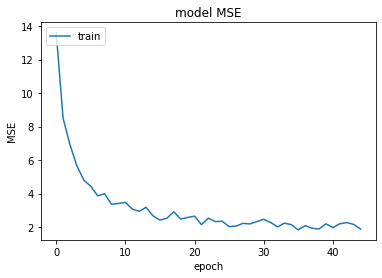

In [11]:
plt.plot(history1.history['loss'][:])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [0]:
pred_2 = model.predict(X[5841:,:,:,:])

In [47]:
print(mean_squared_error(Y[5841:], pred_2, squared = False),
      mean_absolute_error(Y[5841:], pred_2),
      r2_score(Y[5841:], pred_2),
      np.corrcoef(Y[5841:], np.reshape(pred_2, (1, np.shape(pred_2)[0])))[0,1])

2.636654018637716 1.8547364497939822 0.7350996054219748 0.8788127785600224


In [0]:
from keras.models import Model

model_1 = tf.compat.v1.keras.Model(inputs=model.inputs, outputs=model.layers[1].output)

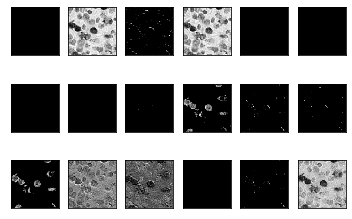

In [27]:
from matplotlib import pyplot

feature_maps = model_1.predict(np.reshape(X[6000,:,:,:], (1, 267, 267, 3)))

# plot all 64 maps in an 8x8 squares

ix = 1
for _ in range(3):
	for _ in range(6):
		# specify subplot and turn of axis
		ax = pyplot.subplot(3, 6, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 265, 265, 18)      504       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 132, 132, 18)      0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 132, 132, 18)      72        
_________________________________________________________________
dropout_4 (Dropout)          (None, 132, 132, 18)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 130, 130, 36)      5868      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 65, 65, 36)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 65, 65, 36)       

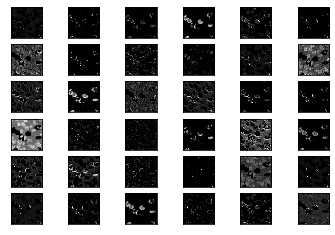

In [36]:
from matplotlib import pyplot

model_2 = tf.compat.v1.keras.Model(inputs=model.inputs, outputs=model.layers[5].output)

feature_maps_2 = model_2.predict(np.reshape(X[6000,:,:,:], (1, 267, 267, 3)))

# plot all 64 maps in an 8x8 squares

ix = 1
for _ in range(6):
	for _ in range(6):
		# specify subplot and turn of axis
		ax = pyplot.subplot(6, 6, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps_2[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

In [0]:
pred = model.predict(X[5841:,:,:,:])

In [15]:
print(mean_squared_error(Y[5841:], pred, squared = False),
      mean_absolute_error(Y[5841:], pred),
      r2_score(Y[5841:], pred))

2.9166619911113716 1.749394416780481 0.6758481396165554


In [0]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

In [0]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [0]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, 
                 data_format="channels_last"))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))

model.compile(loss="MAE", optimizer=keras.optimizers.Adadelta(),metrics=['MSE'])

In [0]:
model.fit(x, Y[:1000], batch_size=batch_size, epochs=5,  verbose=1)

Epoch 1/5
 384/1000 [==========>...................] - ETA: 7:29 - loss: 2.7396 - MSE: 32.0625

KeyboardInterrupt: 

In [0]:
pred_x= model.predict(x)

In [0]:
np.sum(pred_x)

0.0